In [1]:
import pandas as pd
import numpy as np
import sklearn.decomposition
from scipy import stats
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import emcee
import tissue_enrichment_analysis as tea
import matplotlib.patheffects as path_effects
import morgan as morgan

import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting

import networkx as nx
import matplotlib as mpl
from matplotlib import rc
rc('text', usetex=True)

# Display graphics in this notebook
bokeh.io.output_notebook()


# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
# sns.set_style('darkgrid', rc=rc)
sns.set_style("dark")

import genpy

ft = 35 #title fontsize

Loading BokehJS ...

In [2]:
phenotype_df = pd.read_csv('../input/dictionaries/phenotype_dictionary.csv')
tissue_df = tea.fetch_dictionary()
tf_df = pd.read_csv('../input/tf_list.csv')

genotype_mapping = {'a': r'\emph{egl-9;vhl-1}',
                    'f': r'\emph{egl-9;hif-1}',
                    'b': r'\emph{egl-9}',
                    'c': r'\emph{hif-1}',
                    'd': r'\emph{vhl-1}',
                    'e': r'\emph{rhy-1}',
                    'g': r'\emph{fog-2}'
                    }

# Mutants:

I have been given 4 single mutants and 2 double mutants. This is a blind study, so I don't know the identities of the mutants. 

Single mutants:

b, c, d, e

Double mutants:
$$
a = b^-d^-
$$

$$
f = b^-c^-
$$

In [3]:
# Specify the genotypes
single_mutants = ['b', 'c', 'd', 'e', 'g']
double_mutants = {'a' : 'bd', 'f':'bc'}

thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')
thomas.add_single_mutant(single_mutants)
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# Make all possible combinations of WT, X
combs = {}
for gene in thomas.genmap.genotype.unique():
    if gene != 'wt':
        combs[gene] = 'WT_'+gene+'/'

# load all the beta values for each genotype:
sleuth_loc = '../sleuth/'
thomas.add_betas(sleuth_loc, 'betas.csv', combs)

thomas.filter_data(0, 0.1)

Number of na genes: 1005


# PCA Analysis of TPM Data

PCA analysis of TPM data should hopefully reveal some structure and clustering in this dataset. 

First, I want to know how many PCs explain >90% of the data, then build a PCA object with that
many dimensions which I will use for agglomerative clustering. 

In [4]:
# PCA
#exclude g
pca_matrix = genpy.make_matrix(thomas.tpm, thomas.genmap, 'project_name', 'tpm')
sklearn_pca, n = genpy.pca(pca_matrix)

The first 2 principal components explain >=90% of the data


In [5]:
# keep only the first principal components that explain 90% of the data
if n < 3:
    n = 3

df_nD = genpy.tidy_pca(pca_matrix, n)

# add a sample and genotype column
df_nD['samples'] = thomas.genmap.project_name.unique()
l = lambda x: thomas.genmap[thomas.genmap.project_name == x].genotype.values[0]
df_nD['genotypes'] = df_nD.samples.apply(l)
df_nD.head()

,PCA1,PCA2,PCA3,samples,genotypes
0,-6651.043509,7592.903875,728.364645,Project_17434_indexN704-N517,wt
1,-9587.120860,-11366.065534,3467.637552,Project_17441_indexN704-N508,a
2,-9578.267447,3484.945415,-4687.500116,Project_17448_indexN705-N507,d
3,-6049.429847,7573.421005,-1983.077190,Project_17435_indexN704-N502,wt
4,-7517.120059,-10030.140536,2786.306948,Project_17442_indexN705-N517,a


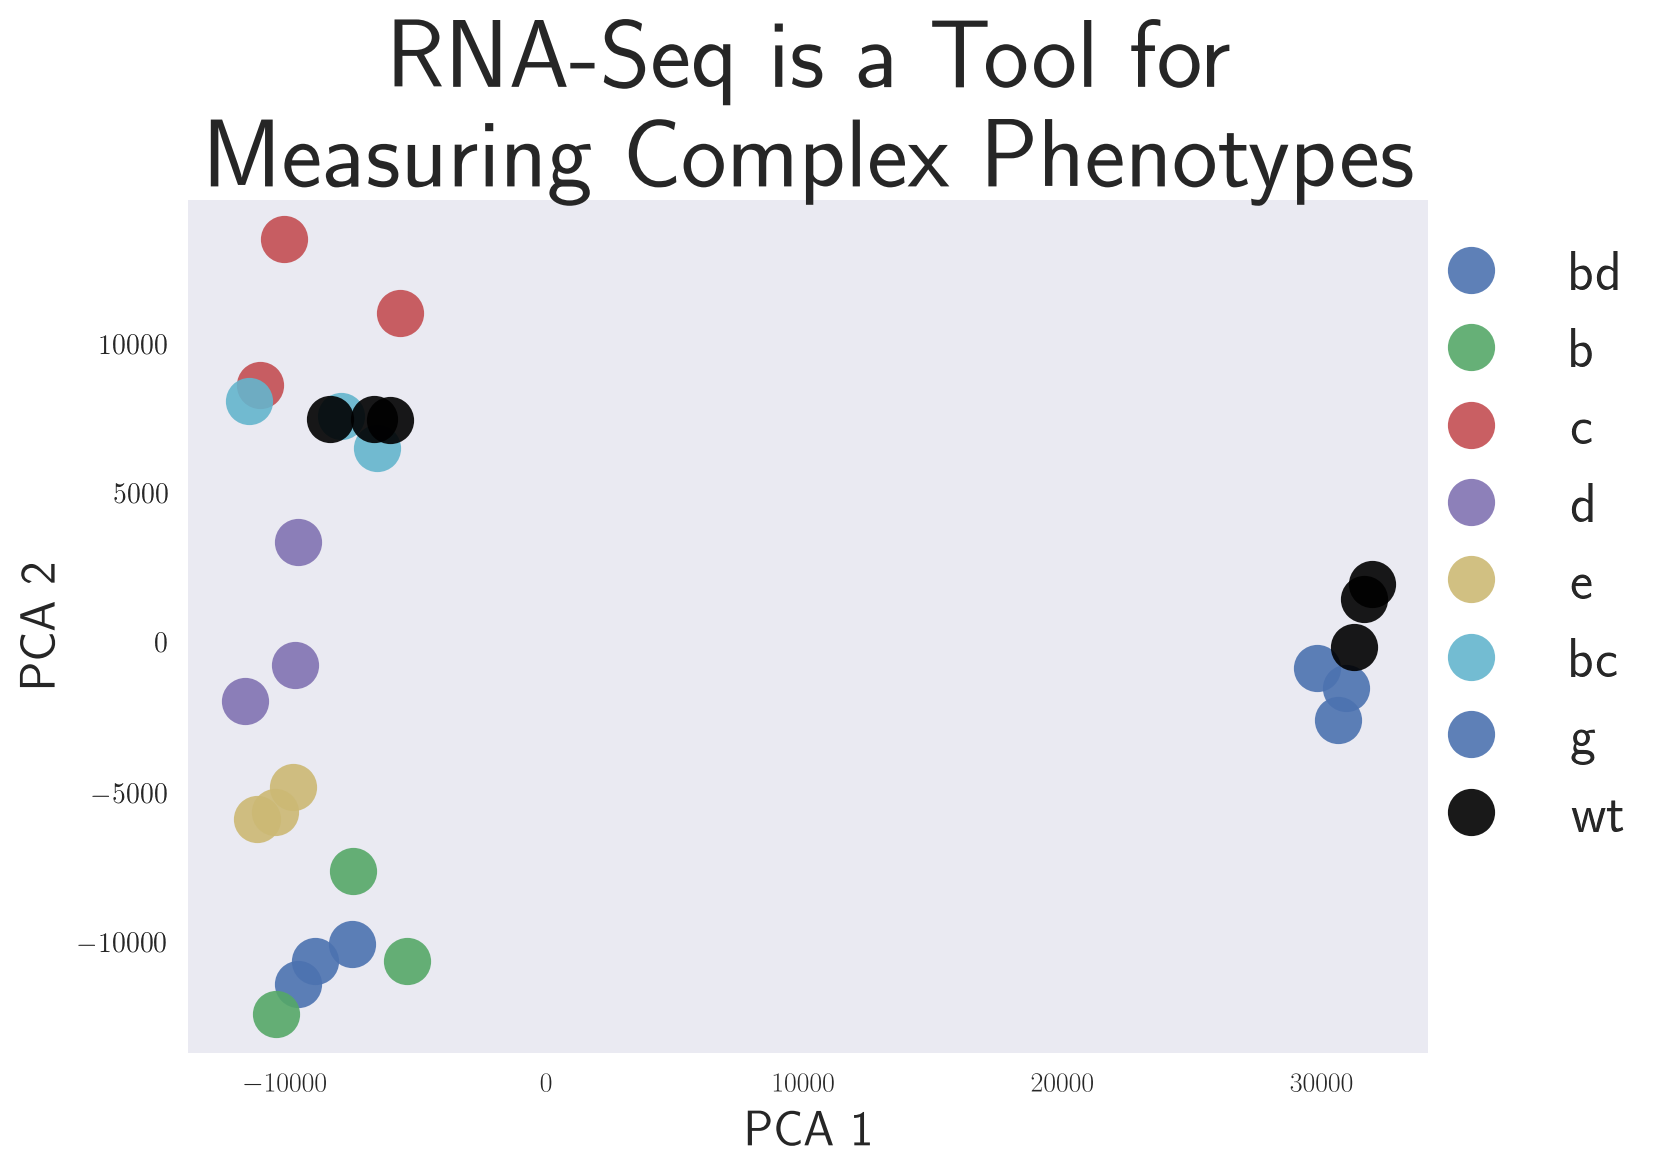

In [6]:
def plot_2d_pca(df_pca, group_col, special_key, double_mutant_hash= {},save=''):
    """
    Very basic wrapper around plt.plot to plot pca results after using tidy_pca.
    
    df_pca - df output by tidy_pca
    group_col - column in df_pca to group by
    special_key - if there's a particular group to color in black, use special_key
                  to identify it
    
    returns:
    a matplotlib object
    """
    # plot first 2d components! 
    for key, group in df_nD.groupby(group_col):
        if key == special_key:
            plt.plot(group.PCA1, group.PCA2, 'ko', alpha=0.9, label=key, ms=17)
        else:
            if key not in double_mutant_hash.keys():
                plt.plot(group.PCA1, group.PCA2, 'o', alpha=.9, label=key, ms=17)
            else:
                plt.plot(group.PCA1, group.PCA2, 'o', alpha=.9, label=double_mutant_hash[key], ms=17)

    # Tidy up plot
    plt.legend(bbox_to_anchor=(1.2, 1), fontsize=20).set_path_effects([path_effects.Normal()])
    plt.margins(0.05)
    plt.xlabel('PCA 1').set_path_effects([path_effects.Normal()])
    plt.ylabel('PCA 2').set_path_effects([path_effects.Normal()])
    if save:
        plt.savefig(save)
    
    
plot_2d_pca(df_nD, 'genotypes', 'wt', double_mutants)

ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()[::1]):
    ax.get_xticklabels()[::1][i] = ax.get_xticklabels()[::1][i].set_path_effects([path_effects.Normal()])

    
import matplotlib.ticker as plticker

loc = plticker.MultipleLocator(base=10**4) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = plticker.MultipleLocator(base=5*10**3) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)

plt.title('RNA-Seq is a Tool for\nMeasuring Complex Phenotypes', fontsize=ft).set_path_effects([path_effects.Normal()])
plt.savefig('../output/tpm_pca.pdf', bbox_inches='tight')


Clearly, we can see a few things:

b, e and d all cluster far away from the WT, primarily along PCA1. 

The double mutant f has a mean PCA location very close to b. 

Mathematically:
$$
b^-d^- \sim b^-
$$

The mutant c has a centroid relatively close to the WT. 

The double mutant f is almost identical to the WT:
$$
b^-c^- \sim WT
$$

However, we are only looking at the first 2 dimensions of the PCA, and we know that 90% of the variance is contained in the first 4. So we can perform agglomerative clustering to make sure these observations are correct. 

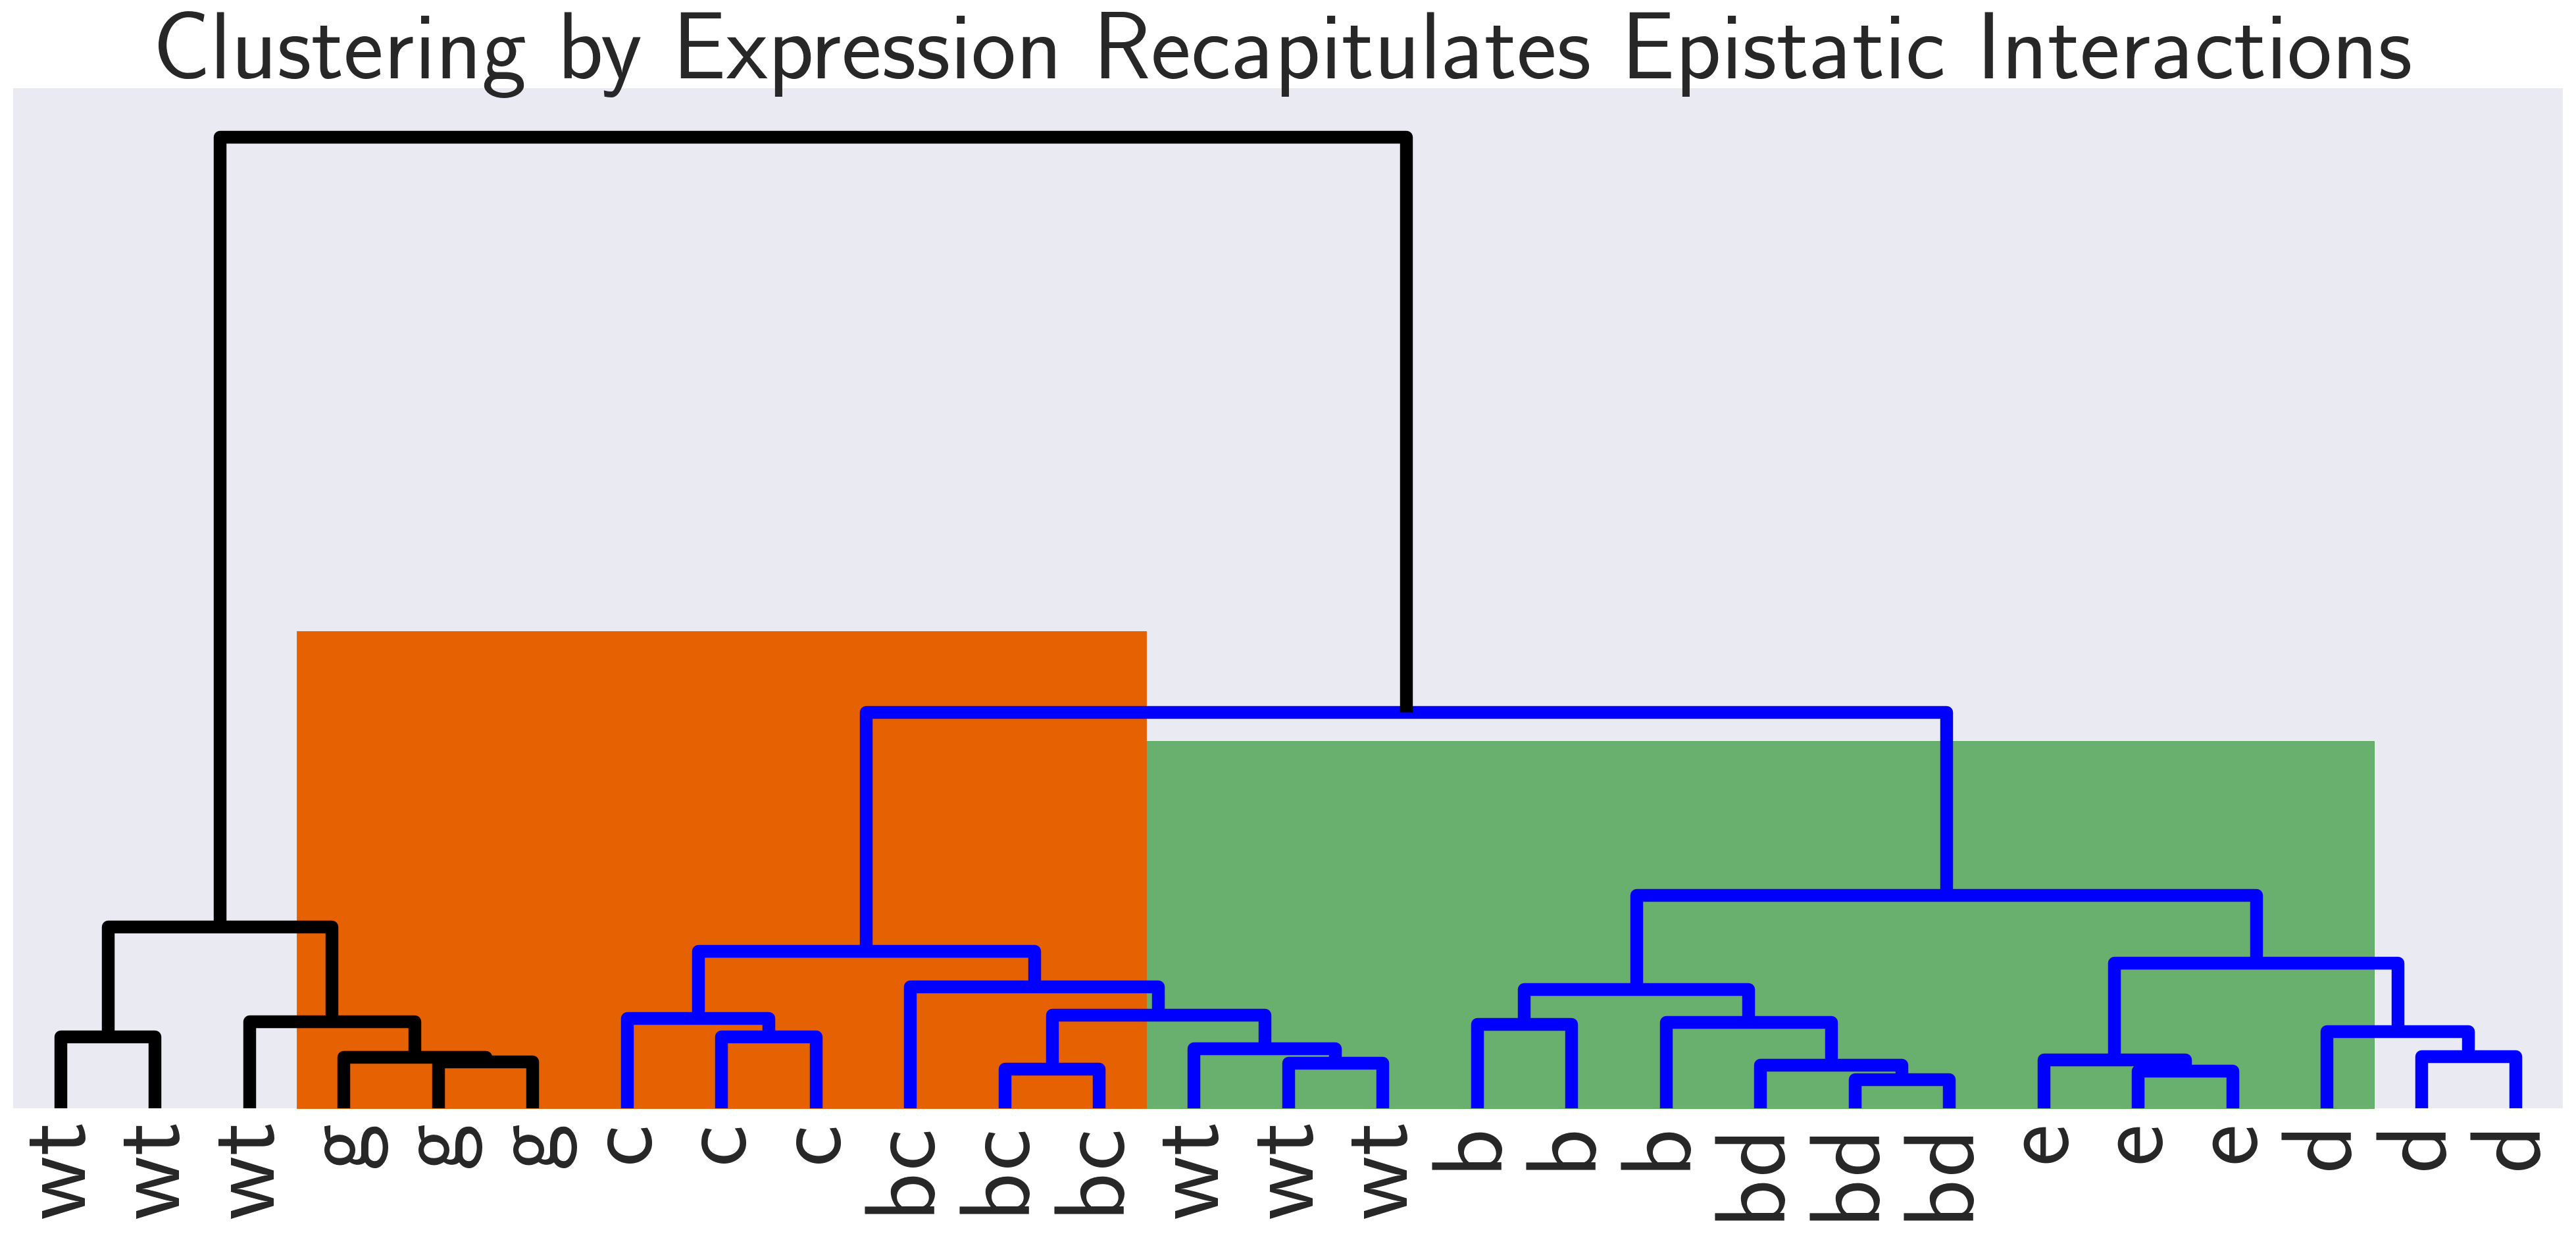

In [7]:
model = hierarchy.linkage(sklearn_pca.transform(pca_matrix), 'ward')
plt.figure(figsize=(25, 10))

labels = df_nD.genotypes.values

for i, label in enumerate(labels):
    if label in double_mutants:
        labels[i] = double_mutants[label]

# ax, fig = plt.subplots()
plt.rcParams['lines.linewidth'] = 7

hierarchy.set_link_color_palette(['k', 'b'])
# fig, ax = plt.subplots()

hierarchy.dendrogram(
    model,
    truncate_mode='level',  # show only the last p merged clusters
    labels=df_nD.genotypes.values,
    p=21,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    above_threshold_color='k'
)

ax = plt.gca()
height = ax.get_ylim()[1]*.36
ax.fill_between([120, 250], 0.0, height, 
                    where=[1,1], color='g', alpha=0.55, zorder=0)
ax.fill_between([30, 120], 0.0, height*1.3, 
                    where=[1,1], color='#e66101', alpha=1, zorder=0)

plt.xticks(fontsize=55)
plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.yticks(fontsize=30)
plt.title('Clustering by Expression Recapitulates Epistatic Interactions', fontsize=ft*1.5)
# plt.xlabel('sample index', fontsize=40)
# plt.ylabel('distance', fontsize=40)
plt.savefig('../output/tpm_dendrogram.pdf', bbox_inches='tight')

In fact, it does appear that 
$$
f \sim WT
$$

$$
a \sim b
$$

$$
|c - WT| = min~|g - WT|~ \mathrm{for }~~ g~\in~[b, c, d, e]
$$

Where this last expression means: C is closest to the WT out of [b, c, d, e]

# PCA Based On Stat. Sig. Gene Changes Is Not Helpful

Before we did PCA based on total TPM counts for every gene. In this next section, we will see that clustering genotypes by statistically significant gene changes is not helpful.

The reason is simple. PCA is a variance maximization tool. Feeding in the calculated log linear regression slopes from sleuth (trimmed so that all the NAs are gone) is (anthropomorphizing) like telling the computer what genes to use to identify each genotype. Feeding in the information about what genes really change will make it easier to find just a very few dimensions that allow us to separate the points easily. So, what we will see is that in general feeding in the log linear regressions will  
* Allow us to find PCA components that better separate each genotype
* Allow us to find less PCA components that cumulatively explain the variance in the data
* As a result of this, more subtle effects can be observed, but tight relationships between genotypes become less obvious (subtle differences play a larger role)

At any rate, it's a good idea to filter the data by TPM, 'fold change' and qvalues, so we will go ahead and do this now. 

In [8]:
# # Figure out what genes are in 10% or above expression in TPM for all samples. Delete anything below that...
thomas.filter_data(0, 0.1)

Number of na genes: 1005


# Filtering Does Not Seriously Alter Differentially Expressed Genes

In [9]:
q = 0.1
for key, df in thomas.beta.items():
    sig_genes = len(df[df.qval < q])
    mc = np.exp(df[df.qval < q].b.abs().max())
    print('{0} has {1} diff. exp. genes before filtering with mean fold change {2:.2g}'.format(key, sig_genes, mc))
    df = thomas.beta_filtered[key]
    sig_genes = len(df[df.qval < q])
    print('{0} has {1} diff. exp. genes after filtering'.format(key, sig_genes))
    print('-----------\n')


c has 937 diff. exp. genes before filtering with mean fold change 3.2e+02
c has 923 diff. exp. genes after filtering
-----------

e has 2457 diff. exp. genes before filtering with mean fold change 6e+02
e has 2398 diff. exp. genes after filtering
-----------

b has 1813 diff. exp. genes before filtering with mean fold change 7.7e+02
b has 1755 diff. exp. genes after filtering
-----------

d has 977 diff. exp. genes before filtering with mean fold change 1.9e+03
d has 958 diff. exp. genes after filtering
-----------

g has 1639 diff. exp. genes before filtering with mean fold change 3.3e+04
g has 1596 diff. exp. genes after filtering
-----------

f has 367 diff. exp. genes before filtering with mean fold change 1.6e+03
f has 362 diff. exp. genes after filtering
-----------

a has 2812 diff. exp. genes before filtering with mean fold change 4e+02
a has 2728 diff. exp. genes after filtering
-----------



# PCA with 'fold changes':

This will separate the genotypes out well, but it's not going to be as informative -- the information has been processed relative to wildtype, so the question this asks is: How different are the genotypes? Since the data has been processed, it's already in an ideal format to separate the genotypes (i.e., diff. expressed genes). 

The first 3 principal components explain >=90% of the data


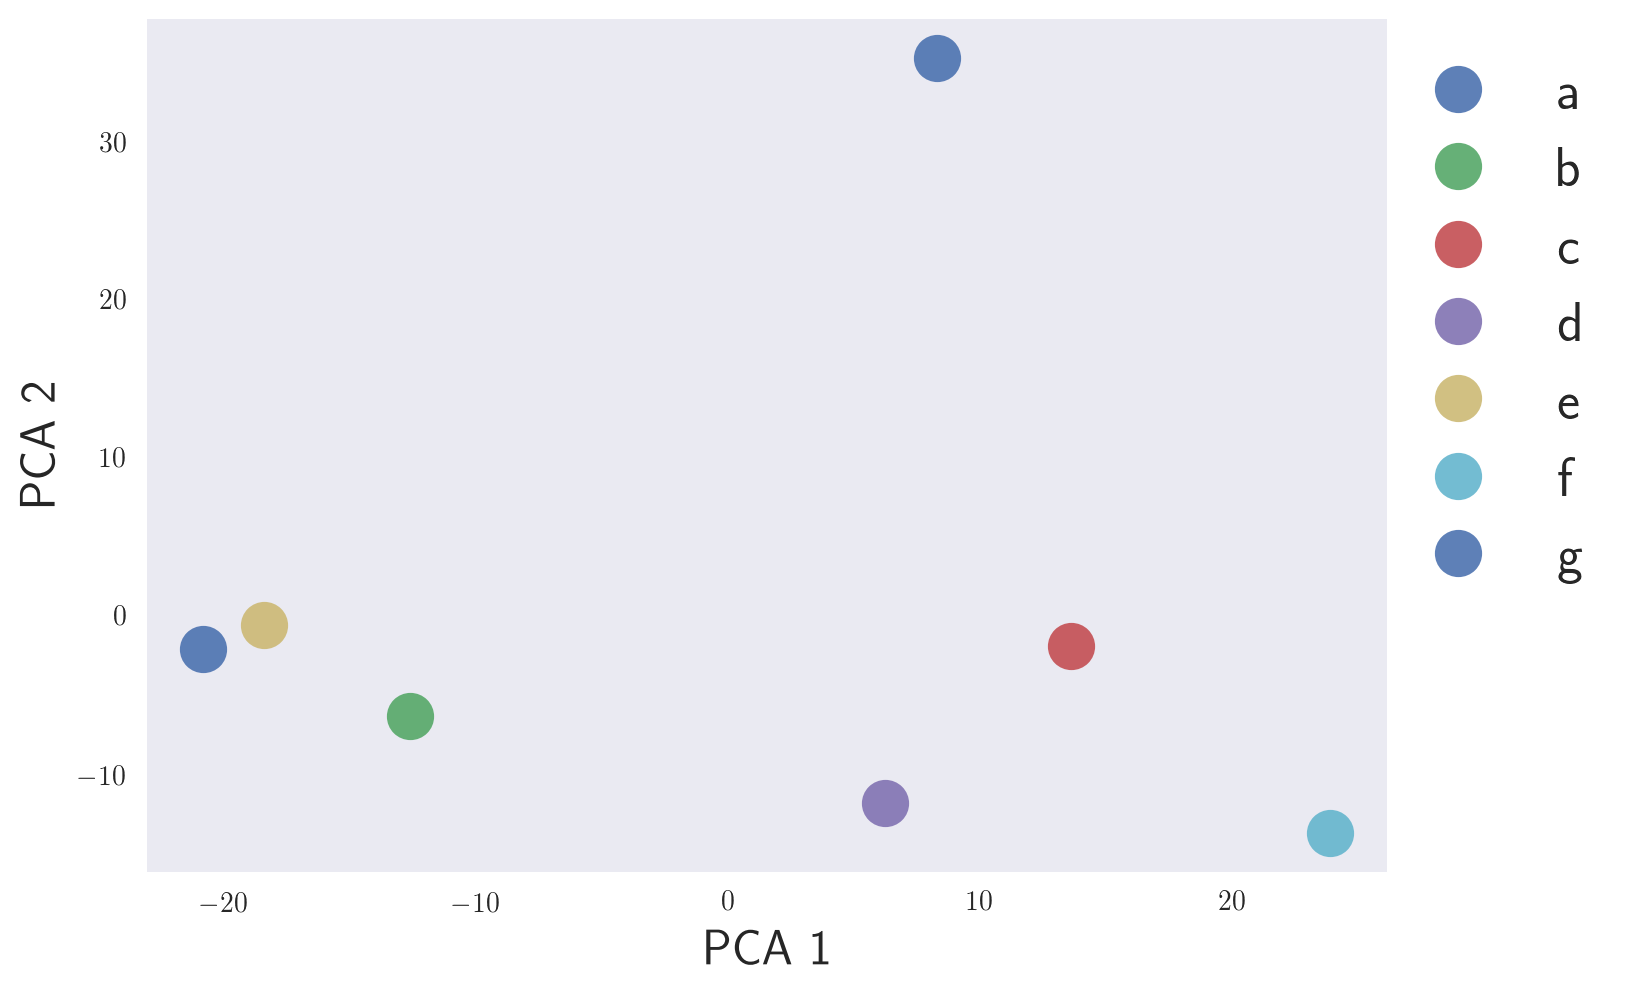

In [10]:
# PCA
pca_matrix = genpy.make_matrix(thomas.beta_filtered, thomas.genmap[(thomas.genmap.genotype != 'wt') ],
                               'genotype', 'qval')
sklearn_pca, n = genpy.pca(pca_matrix)
# # keep only the first principal components that explain 90% of the data
df_nD = genpy.tidy_pca(pca_matrix, n)

# # add a sample and genotype column
df_nD['genotypes'] = thomas.genmap[(thomas.genmap.genotype != 'wt') ].genotype.unique()
# df_nD['genotypes'] = thomas.single_mutants
plot_2d_pca(df_nD, 'genotypes', 'wt', save='../output/preliminary_pca.pdf')

# Nomenclature



# Single Mutant Analysis

There seem to be two obvious ways of analyzing this kind of data. By far the simplest method is using Spearman R analysis. 

## Correlational Transcriptome Analysis


## Bayesian Probability of Interaction


## Other kinds of activation



In [11]:
def pathify(title, xlabel, ylabel, xticks=True, yticks=True, **kwargs):
    """
    A function to pathify the labels, titles and ticks in a plot.
    """
    labelsize = kwargs.pop('labelsize', 20)
    titlesize = kwargs.pop('titlesize', 25)

    plt.ylabel(ylabel, fontsize=labelsize).set_path_effects([path_effects.Normal()])
    plt.xlabel(xlabel, fontsize=labelsize).set_path_effects([path_effects.Normal()])
    plt.title(title, fontsize=titlesize).set_path_effects([path_effects.Normal()])

    ax = plt.gca()
    if xticks == True:
        for i, label in enumerate(ax.get_xticklabels()):
            ax.get_xticklabels()[i].set_path_effects([path_effects.Normal()])
    if yticks == True:
        for i, label in enumerate(ax.get_yticklabels()):
            ax.get_yticklabels()[i].set_path_effects([path_effects.Normal()])


# Evaluating the Spearman R method versus Bayesian Regression

398


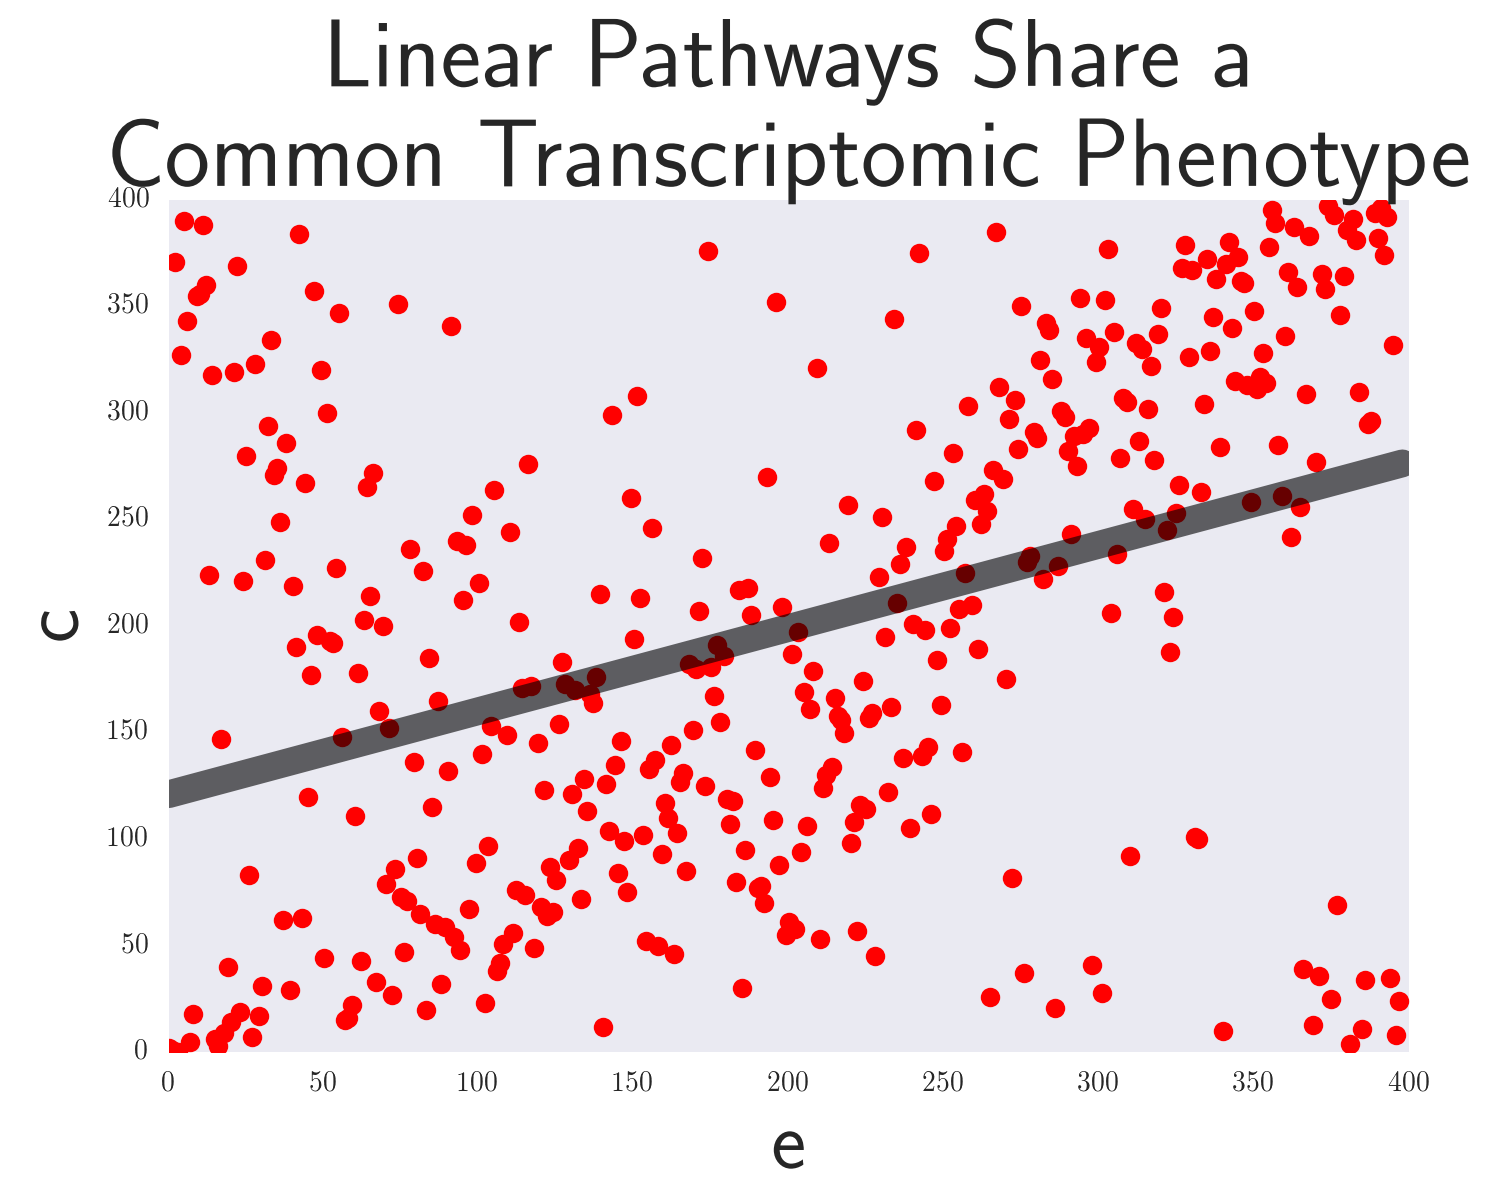

In [12]:
# lambda index function:
lind = lambda x: (x.qval < 0.1)

# As an example, let me show you what a good spearman correlation looks like:
genes = 'target_id'

letters = ['e', 'c']

x = thomas.beta_filtered[letters[0]]
y = thomas.beta_filtered[letters[1]]

ovx = x[lind(x)]
ovy = y[lind(y) & y[genes].isin(ovx[genes])].copy()
ovx = x[lind(x) & x[genes].isin(ovy[genes])].copy()

xns = x[~x.target_id.isin(ovx.target_id)].copy()
yns = y[~y.target_id.isin(ovx.target_id)].copy()

def find_rank(df):
    """A function to find the rank values of a variable."""
    d = df.copy()
    d.sort_values('b', inplace=True)
    rank = np.linspace(0, len(d)-1, len(d))
    d['r'] = rank
    d.sort_values('target_id', inplace=True)
    return d

ovx = find_rank(ovx)
ovy = find_rank(ovy)

slope, intercept, r_value, p_value, std_err = stats.linregress(ovx.r,ovy.r)


print(len(ovx))
X = np.linspace(0, len(ovx.r))
Y = slope*X + intercept

# print('{0:.2g}'.format(r))
plt.plot(ovx.r, ovy.r, 'ro', alpha=1, label='Overlapped Diff. Exp. Genes')

plt.plot(X, Y, 'k-', alpha=0.6, lw=10, label= 'Best Fit')

# plt.xlim(-5, 500)
# plt.ylim(-5, 500)

plt.title('Linear Pathways Share a\nCommon Transcriptomic Phenotype', fontsize=ft).\
            set_path_effects([path_effects.Normal()])
plt.xlabel(letters[0], fontsize=30).set_path_effects([path_effects.Normal()])
plt.ylabel(letters[1], fontsize=30).set_path_effects([path_effects.Normal()])

# plt.xticks([0, 250, 500], fontsize=15)
# plt.yticks([0, 250, 500], fontsize=15)

plt.savefig('../output/spearmanr_b_and_c.pdf')

Spearman R predicts a trend, but the strength is dubious at best. Moreover, there's at least one VERY clear trend line, and the slope is NOT what Spearman predicts. Let's see if we can't do better. 

In [13]:
import pymc3 as pm

import matplotlib.pyplot as plt
import numpy as np

import theano

def robust_regress(data):
    """A robust regression using a StudentT distribution instead of a Gaussian model."""
    with pm.Model() as model_robust:
        family = pm.glm.families.StudentT()
        pm.glm.glm('y ~ x', data, family=family)
        start = pm.find_MAP()
        step = pm.NUTS(scaling=start)
        trace_robust = pm.sample(2000, step, progressbar=True)
        return trace_robust

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.6 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.3 sec

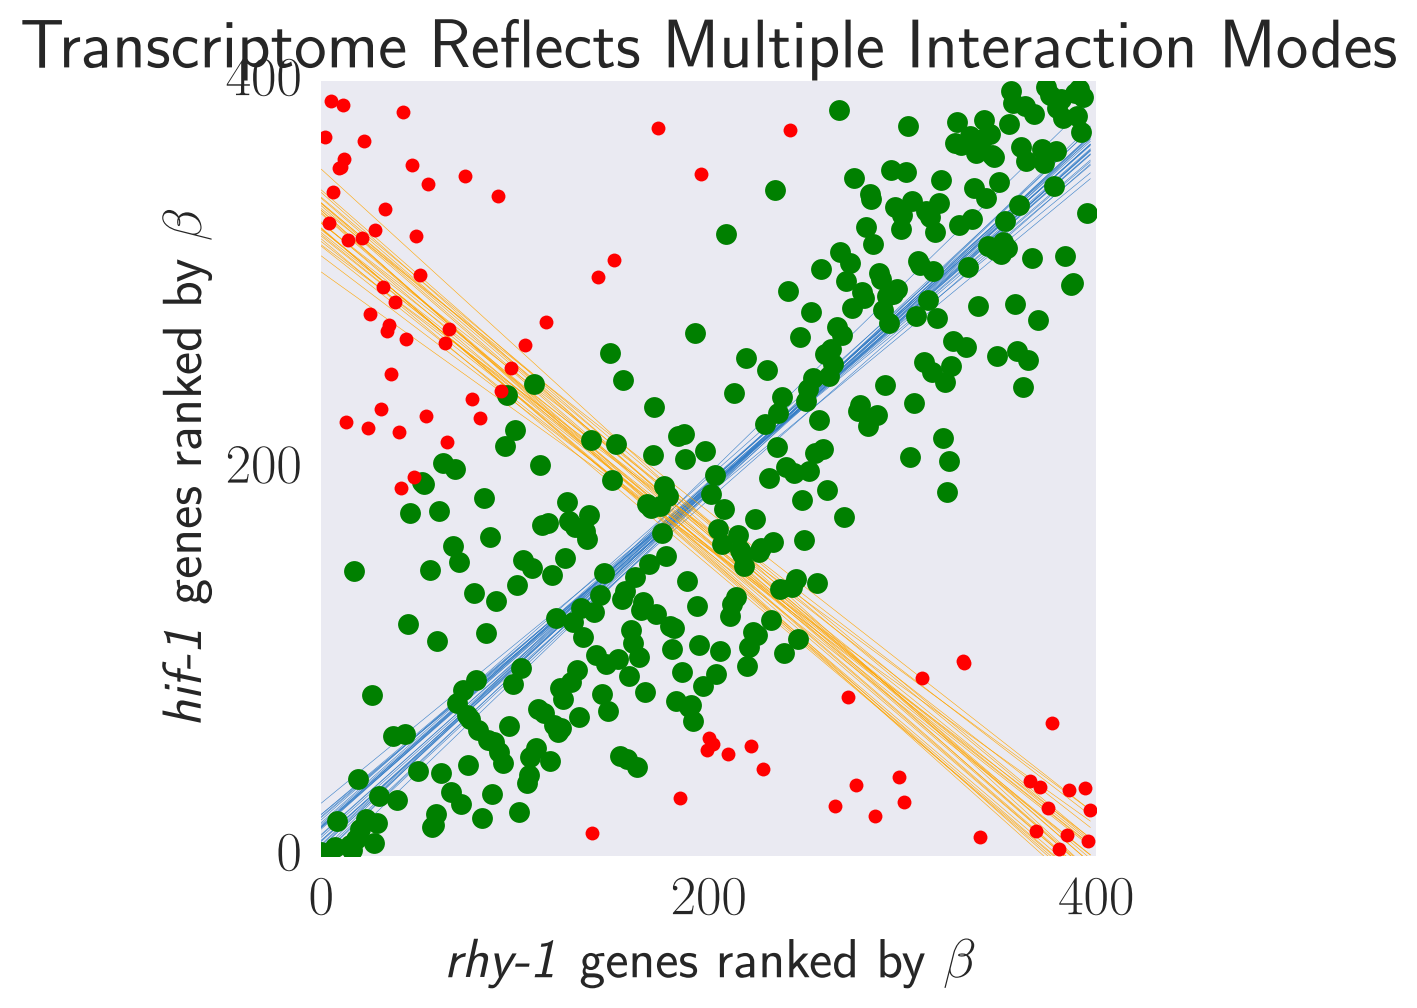

In [14]:
# Set up MCMC parameters
data = dict(x=ovx.r, y=ovy.r)

x = np.linspace(ovx.r.min(), ovx.r.max())
    
trace_robust = robust_regress(data)
plt.figure(figsize=(5, 5))

distribution =ovy.r - trace_robust.Intercept.mean() - ovx.r*trace_robust.x.mean()
mean = distribution.mean()
std = distribution.std()
distribution_inliers = distribution[np.abs(distribution - mean)/(trace_robust.x.std() 
                                                                 + trace_robust.Intercept.std()+ std) < 1]
distribution_outliers = distribution[np.abs(distribution - mean)/(trace_robust.x.std() 
                                                                 + trace_robust.Intercept.std()+ std) > 1]

outliers = ovy[ovy.r.isin(distribution_outliers + 
                          trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean())].target_id

data2 = dict(x=ovx[ovx.target_id.isin(outliers)].r, y=ovy[ovy.target_id.isin(outliers)].r)
trace_robust2 = robust_regress(data2)


yri = distribution_inliers + trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean()
yro = distribution_outliers + trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean()

pm.glm.plot_posterior_predictive(trace_robust, eval=x, 
                                 label='posterior predictive regression lines',
                                 color='#357EC7')
pm.glm.plot_posterior_predictive(trace_robust2, eval=x, 
                                 label='posterior predictive regression lines',
                                 color='#FFA500')

plt.plot(ovx.r, yri, 'go', ms = 7.5)
plt.plot(ovx[yro > 0].r, yro[yro > 0], 'ro', ms = 5)
plt.xlim(0, len(ovx))
plt.ylim(0, len(ovy))
plt.yticks([0, 200, 400], fontsize=20)
plt.xticks([0, 200, 400], fontsize=20)
pathify('Transcriptome Reflects Multiple Interaction Modes', r'\emph{rhy-1} genes ranked by $\beta$', 
        r'\emph{hif-1} genes ranked by $\beta$')
plt.savefig('../output/multiple_modes_{0}.pdf'.format(letters[0]+letters[1]))
# plt.legend()


Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.7 sec

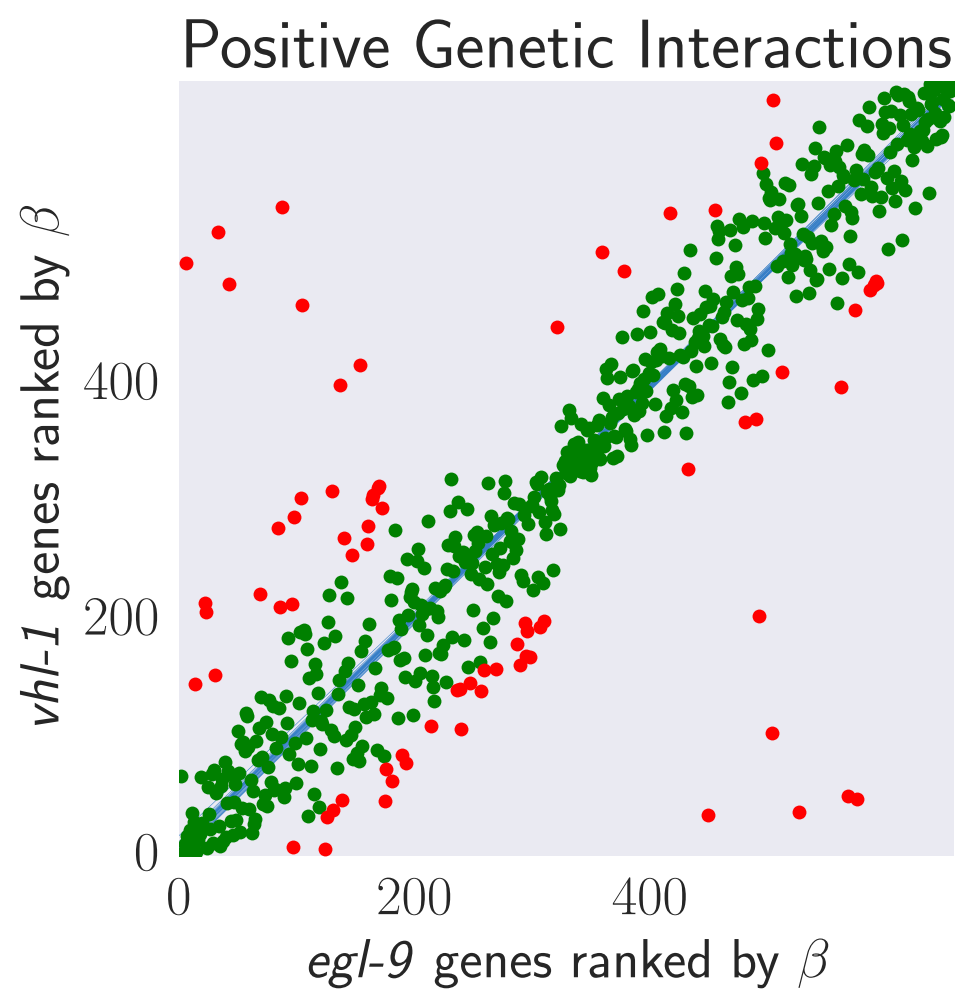

In [15]:
genes = 'target_id'

letters = ['b', 'd']

x = thomas.beta_filtered[letters[0]]
y = thomas.beta_filtered[letters[1]]

ovx = x[lind(x)]
ovy = y[lind(y) & y[genes].isin(ovx[genes])].copy()
ovx = x[lind(x) & x[genes].isin(ovy[genes])].copy()

xns = x[~x.target_id.isin(ovx.target_id)].copy()
yns = y[~y.target_id.isin(ovx.target_id)].copy()

def find_rank(df):
    """A function to find the rank values of a variable."""
    d = df.copy()
    d.sort_values('b', inplace=True)
    rank = np.linspace(0, len(d)-1, len(d))
    d['r'] = rank
    d.sort_values('target_id', inplace=True)
    return d

ovx = find_rank(ovx)
ovy = find_rank(ovy)

# Set up MCMC parameters
data = dict(x=ovx.r, y=ovy.r)

x = np.linspace(ovx.r.min(), ovx.r.max())
    
trace_robust = robust_regress(data)
plt.figure(figsize=(5, 5))

distribution =ovy.r - trace_robust.Intercept.mean() - ovx.r*trace_robust.x.mean()
mean = distribution.mean()
std = distribution.std()
distribution_inliers = distribution[np.abs(distribution - mean)/(trace_robust.x.std() 
                                                                 + trace_robust.Intercept.std()+ std) < 1]
distribution_outliers = distribution[np.abs(distribution - mean)/(trace_robust.x.std() 
                                                                 + trace_robust.Intercept.std()+ std) > 1]

outliers = ovy[ovy.r.isin(distribution_outliers + 
                          trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean())].target_id

# data2 = dict(x=ovx[ovx.target_id.isin(outliers)].r, y=ovy[ovy.target_id.isin(outliers)].r)
# trace_robust2 = robust_regress(data2)


yri = distribution_inliers + trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean()
yro = distribution_outliers + trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean()

pm.glm.plot_posterior_predictive(trace_robust, eval=x, 
                                 label='posterior predictive regression lines',
                                 color='#357EC7')
# pm.glm.plot_posterior_predictive(trace_robust2, eval=x, 
#                                  label='posterior predictive regression lines',
#                                  color='#FFA500')

plt.plot(ovx.r, yri, 'go', ms = 5)
plt.plot(ovx[yro > 0].r, yro[yro > 0], 'ro', ms = 5)
plt.xlim(0, len(ovx))
plt.ylim(0, len(ovy))
plt.yticks([0, 200, 400], fontsize=20)
plt.xticks([0, 200, 400], fontsize=20)
pathify('Positive Genetic Interactions', r'\emph{egl-9} genes ranked by $\beta$', 
        r'\emph{vhl-1} genes ranked by $\beta$')
plt.savefig('../output/positive interaction{0}.pdf'.format(letters[0]+letters[1]))
# plt.legend()

# if np.abs(trace_robust.x.mean()) > 0.6 and np.abs(trace_robust2.x.mean()) > 0.6:
#     t1 = trace_robust.x.mean()/np.abs(trace_robust.x.mean())
#     t2 = trace_robust2.x.mean()/np.abs(trace_robust2.x.mean())
#     if t1 == -t2:
#         print('Complex Regulation at Work')

# Spearman R Analysis

+ c c 937 13598 937 937 1.0
- c c 0 13598 937 937 7.20719808535e-31
+ e c 283 13598 2457 937 0.999999999993
- e c 117 13598 2457 937 1.03357028015e-06
+ d c 166 13598 977 937 1.0
- d c 57 13598 977 937 0.0968662790055
+ g c 45 13598 1639 937 3.4027358074e-15
- g c 124 13598 1639 937 0.884460269636
+ b c 216 13598 1813 937 0.999999999994
- b c 108 13598 1813 937 0.0489352041198
+ c e 283 13598 937 2457 0.999999999993
- c e 117 13598 937 2457 1.03357028016e-06
+ e e 2457 13598 2457 2457 1.0
- e e 0 13598 2457 2457 5.48092823115e-238
+ d e 658 13598 977 2457 1.0
- d e 32 13598 977 2457 1.40527737868e-48
+ g e 240 13598 1639 2457 4.97105094455e-05
- g e 224 13598 1639 2457 2.21037383388e-07
+ b e 1361 13598 1813 2457 1.0
- b e 7 13598 1813 2457 1.88334581809e-155
+ c d 166 13598 937 977 0.999999999997
- c d 57 13598 937 977 0.0968662790048
+ e d 658 13598 2457 977 1.0
- e d 32 13598 2457 977 1.40527737866e-48
+ d d 977 13598 977 977 1.0
- d d 0 13598 977 977 1.32627934284e-33
+ g d 105 135

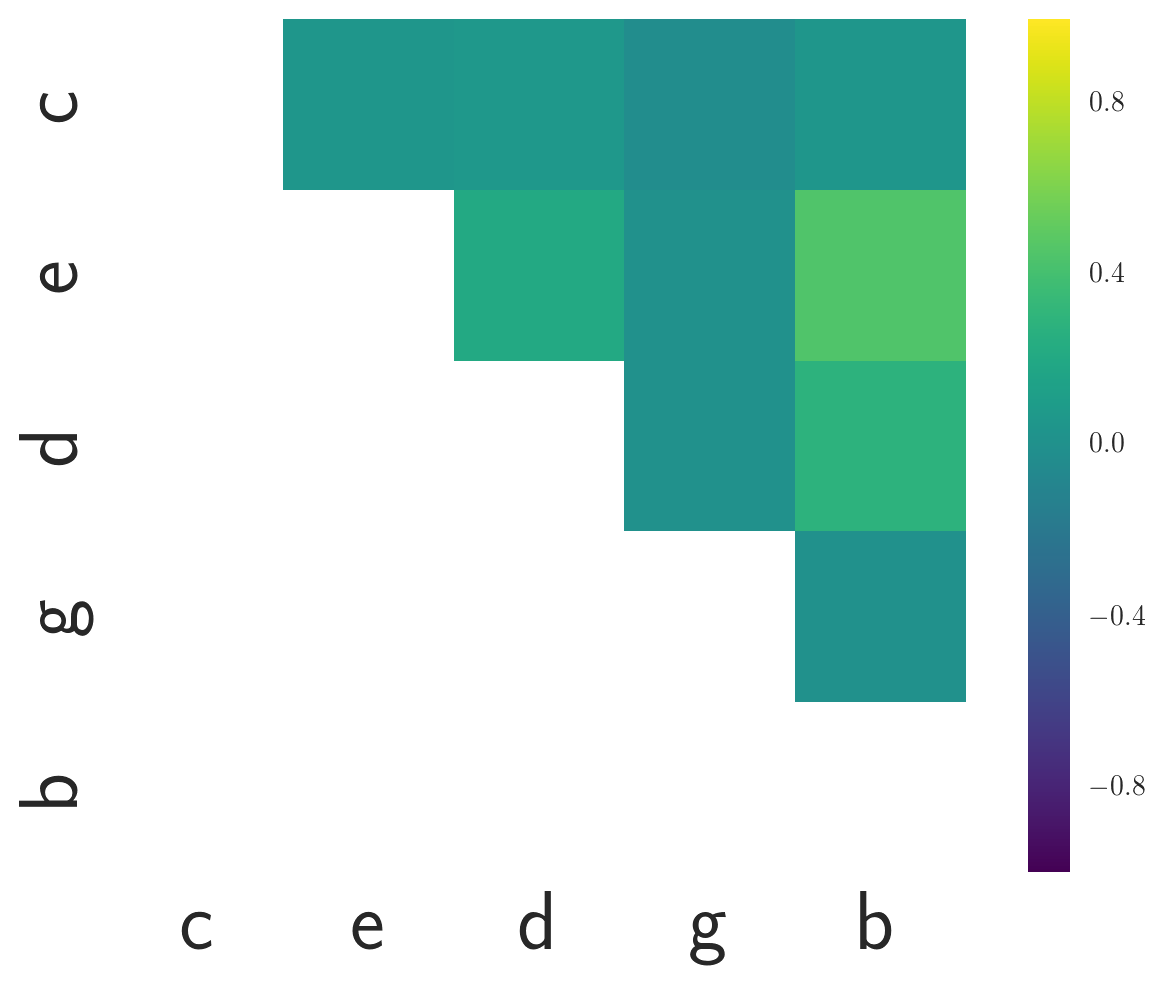

In [16]:
# Perform Correlation Analysis
def tri_plot(matrix, xlabels, ylabels=[]):
    vmin= matrix.min().min()
    vmax= np.max(matrix).max()

    if len(ylabels) == 0:
        ylabels = xlabels
        
    mask = np.zeros_like(matrix)
    mask[np.tril_indices_from(mask)] = True
    with sns.axes_style("white"):
        ax = sns.heatmap(matrix, xticklabels=xlabels, yticklabels=ylabels, cmap='viridis',
                         mask=mask, square=True, vmin=vmin, vmax=vmax)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)


sydney = morgan.brenner('spearman', thomas)
tri_plot(sydney.rho.as_matrix(columns=thomas.single_mutants), thomas.single_mutants)
# plt.title('Robust Bayesian Correlations Predict Interaction Between Genes', fontsize=20)
# plt.savefig('../output/spearmr_matrix_single_mutants.pdf', bbox_inches='tight')

From the above, we can draw the following arrows:


Interaction | $\rho$ |
----------- | ------- |
b -gp- d| 0.92
b -gp- e| 0.96
d -gp- e| 0.81
d -g- c| 0.53
b -g- c| 0.38
e -g- c| 0.41

Due to the weakness of the spearman correlation of b, d, e with c, we can't draw any conclusions about its sign


# Hypergeometric Analysis:

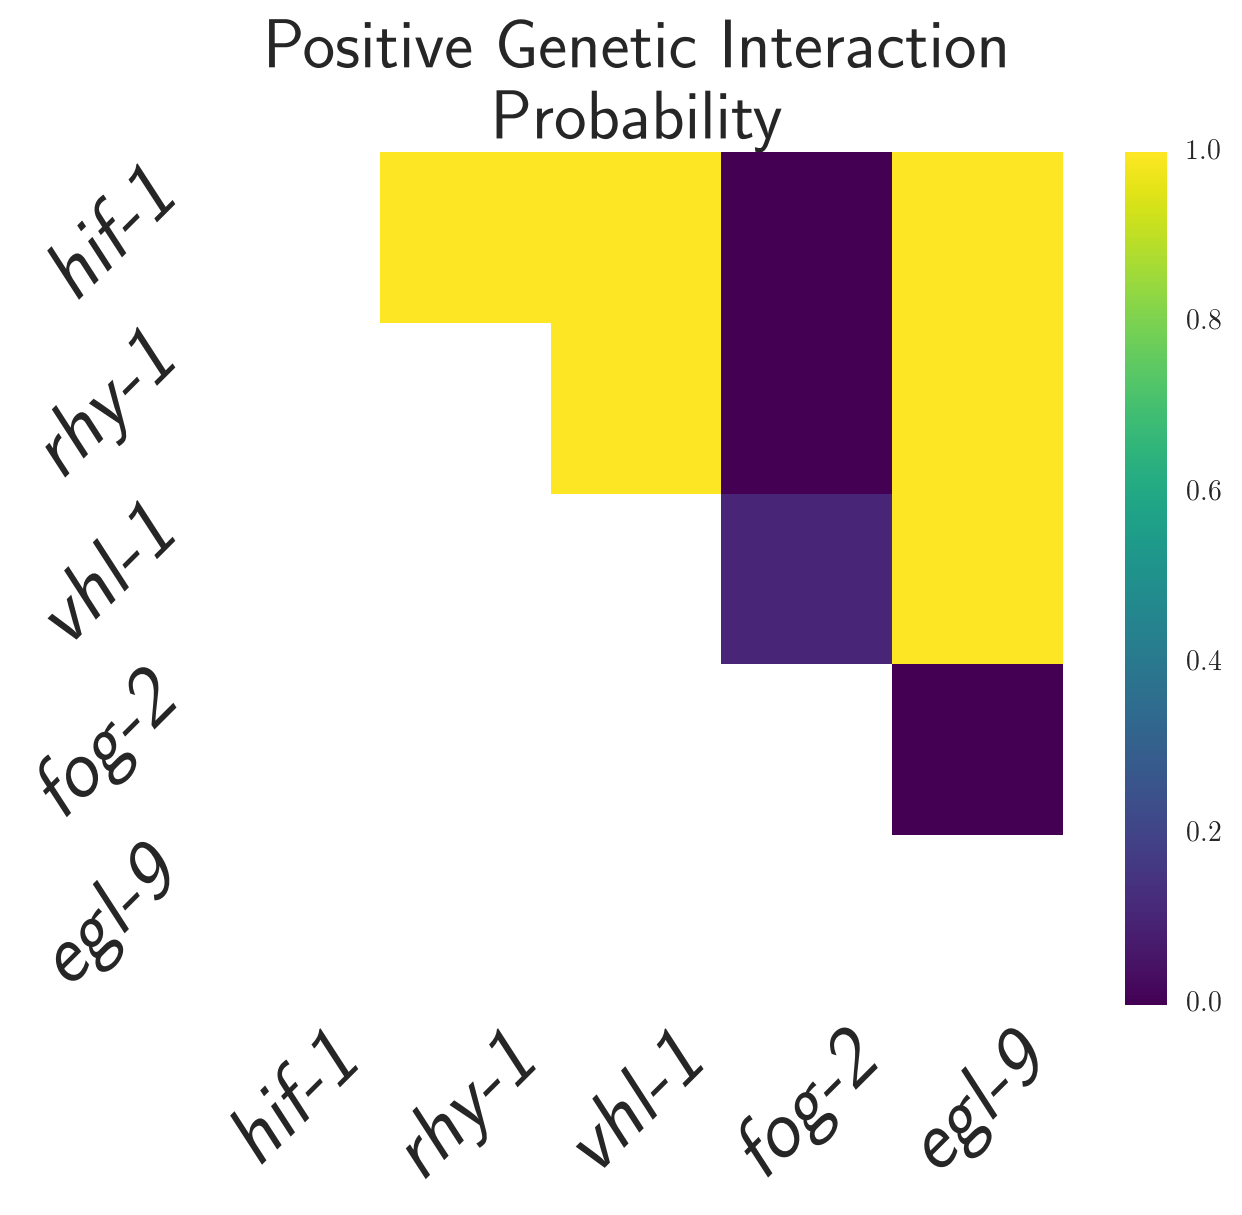

In [17]:
mat = sydney.hyper_plus.as_matrix(columns=thomas.single_mutants)
genes = [genotype_mapping[x] for x in thomas.single_mutants]
tri_plot(mat, genes)
pathify('Positive Genetic Interaction\nProbability', '', '')
plt.yticks(rotation=45)
plt.xticks(rotation=45)
plt.savefig('../output/probability_of_interaction_single_mutants.pdf', bbox_inches='tight')

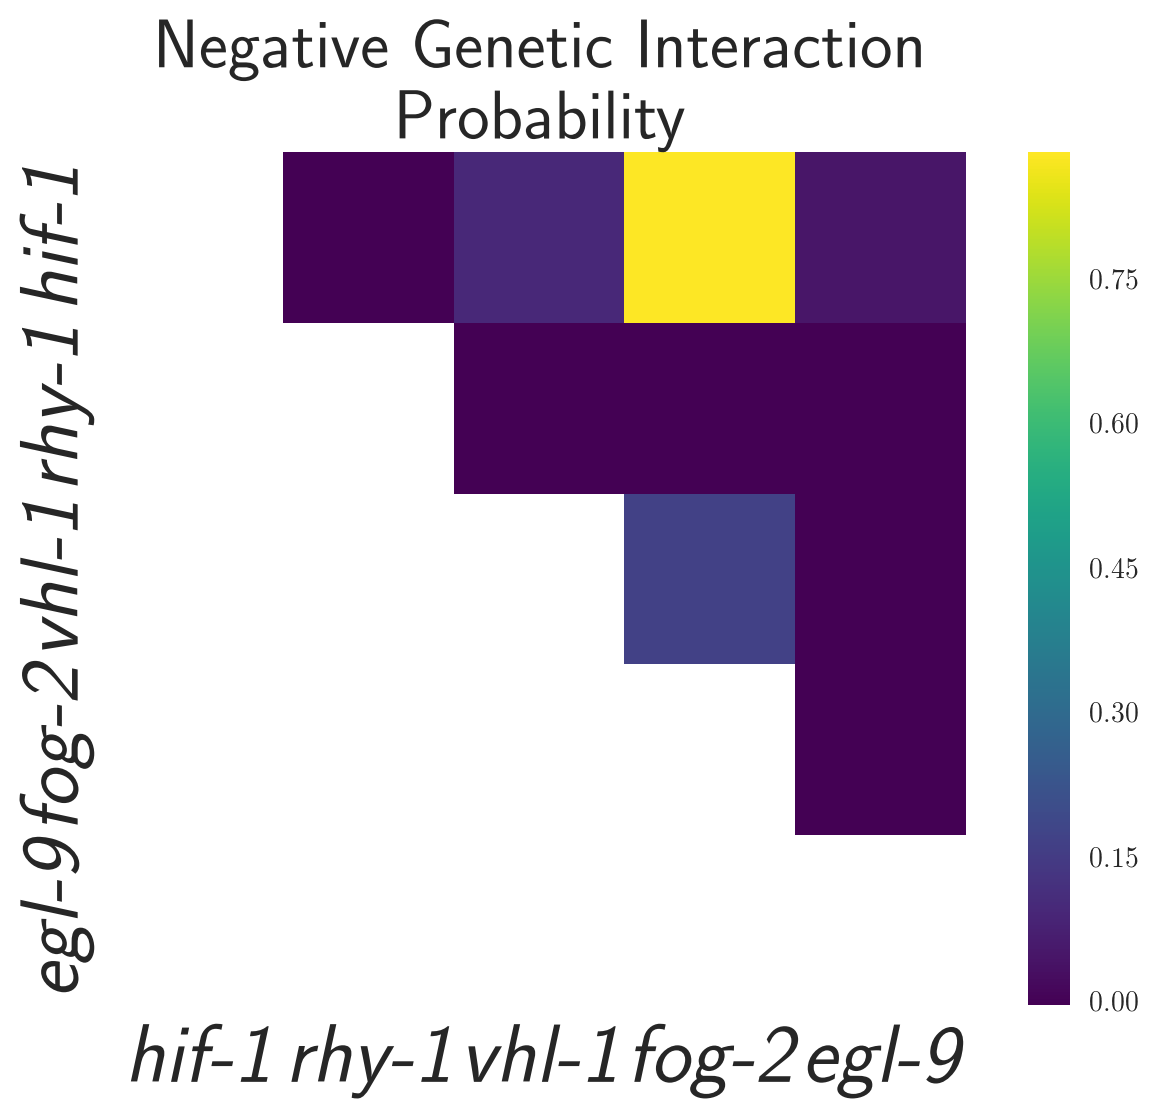

In [18]:
mat = sydney.hyper_minus.as_matrix(columns=thomas.single_mutants)
genes = [genotype_mapping[x] for x in thomas.single_mutants]
tri_plot(mat, genes)
pathify('Negative Genetic Interaction\nProbability', '', '')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.savefig('../output/probability_of_inhibition_single_mutants.pdf', bbox_inches='tight')

# thomas.prob_minus[thomas.prob_minus > 10**-4]

# Analysis Using Robust Spearman Regression

What I do here is try to identify trends. Namely, for two genotypes X and Y, I fit a line using a Bayesian robust regression (see methods) thru the rank-ordered regression coefficients that are statistically significantly different from 0 and that are present in both X and Y. Next, I use this Bayesian framework to identify any and all outliers to the regression. 

In order to test for alternative modes of interaction in this dataset, I take the outliers and I run the same regression again *on the outliers*. If this second interaction has an opposite sign to the first, then we predict that there are two modes of interaction, subject to the following caveats:

 * Both the primary and secondary regressions yield large slopes values (>0.7)
 * The first regression results in many outliers (at least 10% of all the values)

Finally, because of the approach I used, I can also predict which genes are under what mode of regulation. Super cool!

In [19]:
barbara = morgan.mcclintock('bayesian', thomas, True)


starting comparison of c, e
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 sec
starting comparison of c, d
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.7 sec
starting comparison of c, g
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.6 sec
starting comparison of c, b
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.6 sec
starting comparison of e, d
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 2.0 sec
starting comparison of e, g
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-------------

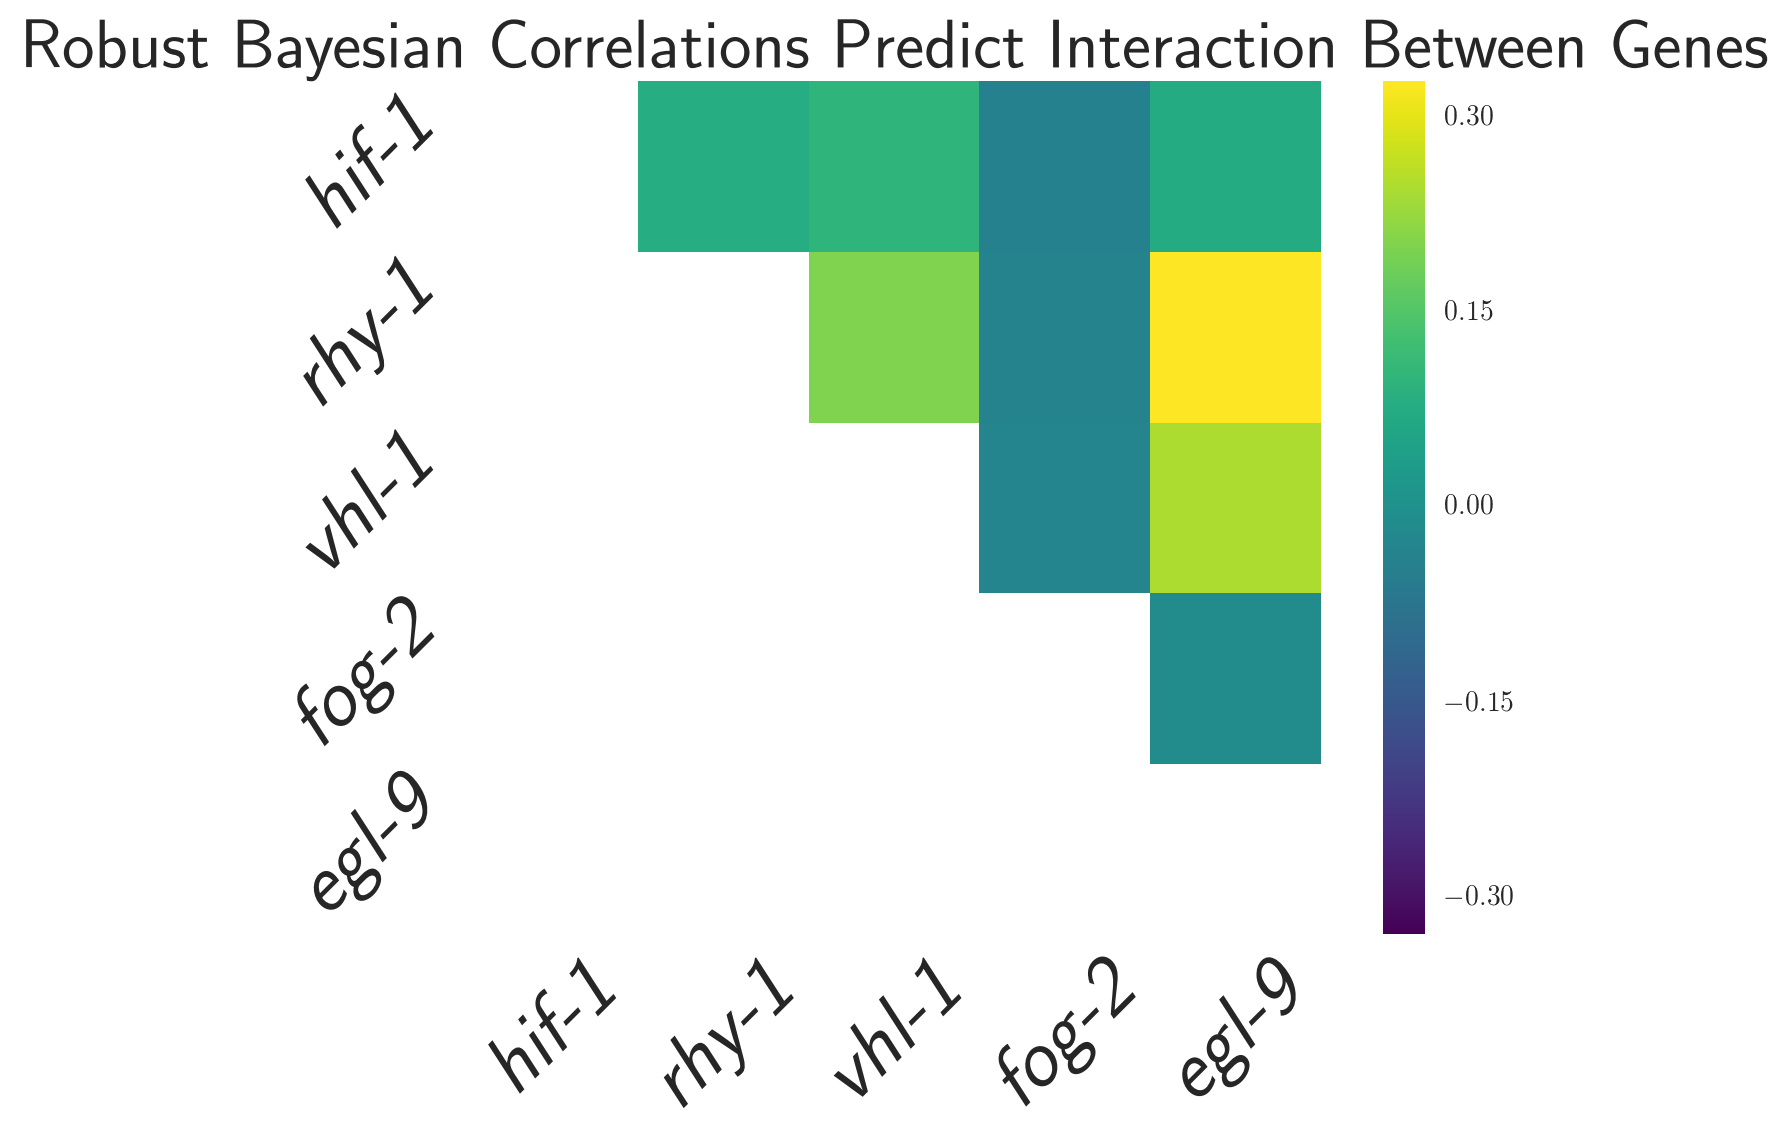

In [20]:
mat = barbara.robust_slope.as_matrix(columns=thomas.single_mutants)
genes = [genotype_mapping[x] for x in thomas.single_mutants]

tri_plot(mat, genes)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
pathify('Robust Bayesian Correlations Predict Interaction Between Genes', '', '')
plt.savefig('../output/bayes_primary_single_mutants.pdf', bbox_inches='tight')

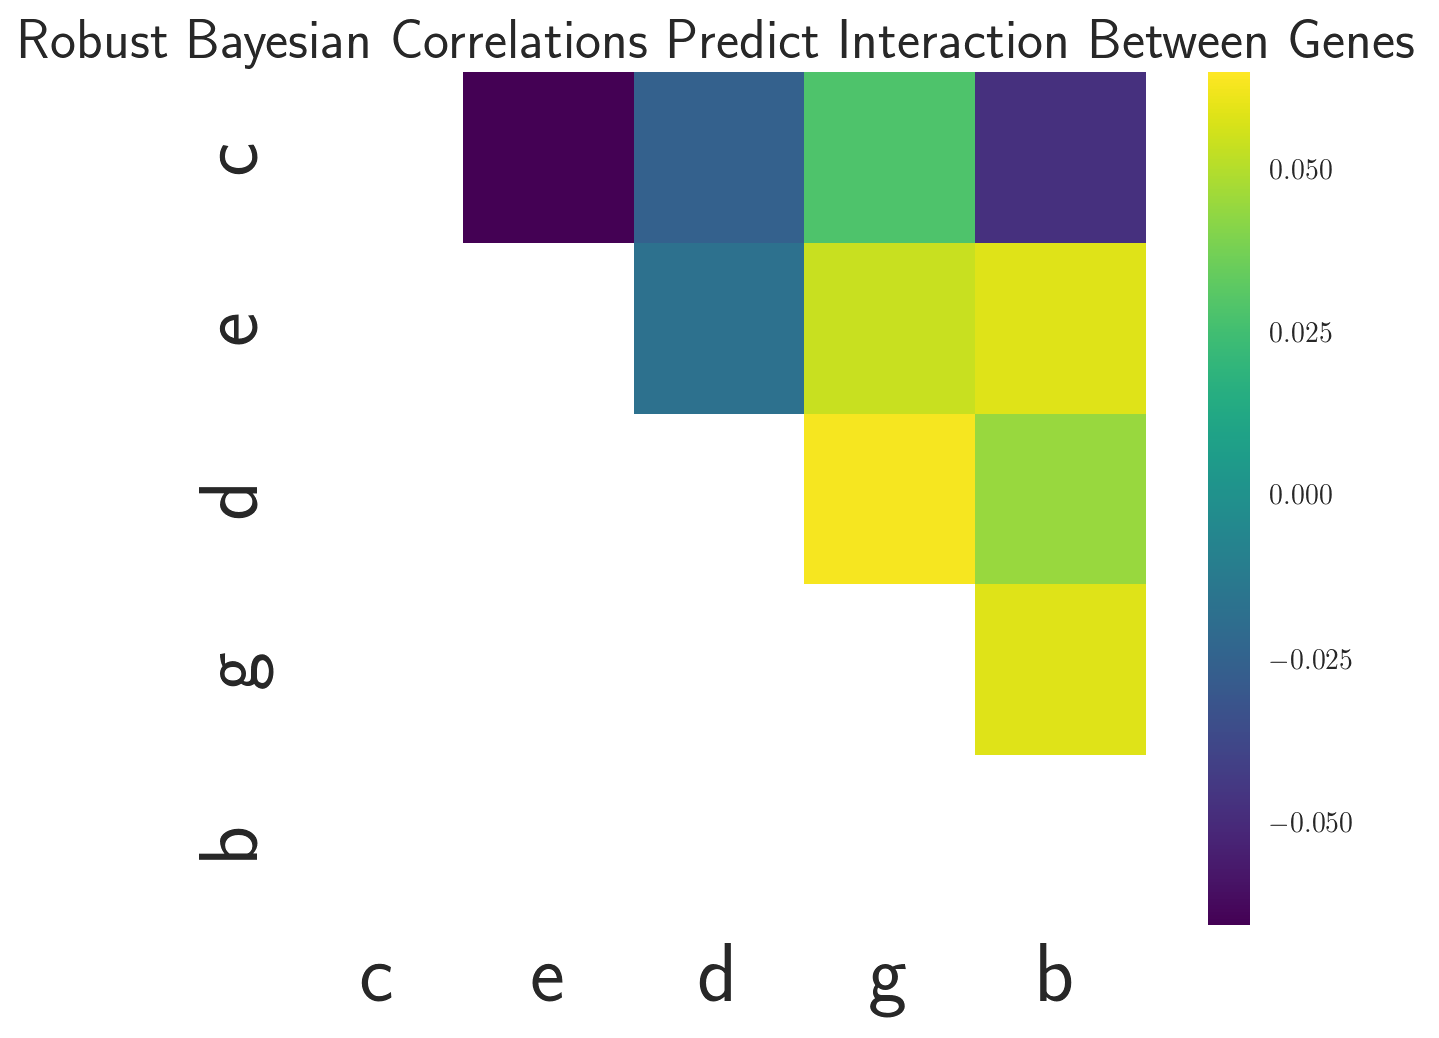

In [21]:
mat = barbara.secondary_slope.as_matrix(columns=thomas.single_mutants)
tri_plot(mat, thomas.single_mutants)
plt.title('Robust Bayesian Correlations Predict Interaction Between Genes', fontsize=20)


Another way to plot the results from the regression above is to make scatterplots. For that, it's best to work with tidy dataframes. 

In [102]:
def tidy_df(df, corr='corr'):
    """
    A function that returns a tidied up dataframe.
    
    Dataframe provided must be the result of morgan.robust_regression()
    or morgan.robust_regression_secondary()
    
    df - dataframe to tidy up
    corr - please specify whether this dataframe is from morgan.robust_regression (write 'corr')
    or from morgan.robust_regression_secondary() (write 'outlier')
    
    outputs:
    df - a tidied dataframe with columns 'corr_wit', 'variable', 'fraction' and 'pair'
    """
    df = df.copy()
    df['corr_with'] = thomas.single_mutants
    df = pd.melt(df, id_vars='corr_with')
    df = df[df.corr_with != df.variable]

#     def add_fraction_overlap(x):
#         if (x.corr_with, x.variable) in barbara.correlated_genes.keys():
#             dd = barbara.correlated_genes[(x.corr_with, x.variable)]
#             corr = len(dd['corr'])
#             total = len(thomas.beta_filtered['a'])  # TODO: make arbitrary variable
#             return corr/total
#         else:
#             return np.nan

    def add_fraction_outliers(x, fraction='corr'):
        if (x.corr_with, x.variable) in barbara.correlated_genes.keys():
            dd = barbara.correlated_genes[(x.corr_with, x.variable)]
            outliers = len(dd['outliers'])
            corr = len(dd['corr'])
            total = outliers + corr
            if fraction == 'corr':
                return corr/total
            else:
                return outliers/total
        else:
            return np.nan

#     df['fraction_overlap'] = df.apply(add_fraction_overlap, axis=1)
    df['fraction_outliers'] = df.apply(add_fraction_outliers, args=(corr,), axis=1)
    df['pair'] =  df.variable + df.corr_with
    return df

d_pos = tidy_df(barbara.robust_slope)
d_pos['regression'] = 'primary'
d_minus = tidy_df(barbara.secondary_slope, corr='outliers')
d_minus['regression'] = 'secondary'

In [103]:
frames = [d_pos, d_minus]
d = pd.concat(frames)

def different(x):
#     if x.regression == 'primary':
#         return np.nan
    p = x.pair
    primary = d[(d.pair == p) & (d.regression == 'primary')].value.values[0]
    secondary = d[(d.pair == p) & (d.regression == 'secondary')].value.values[0]
    
    if primary == 0 or secondary == 0:
        return 0
    elif (primary*secondary > 0):
        return -1
    else:
        return 1

d['different'] = d.apply(different, axis=1)

In [104]:
# def calculate_overlap(x):
#     if (x.variable, x.corr_with) in thomas.overlap_ids_plus.keys():
#         op = len(thomas.overlap_ids_plus[(x.variable, x.corr_with)])
#     else:
#         op = 0
#     if (x.variable, x.corr_with) in thomas.overlap_ids_minus.keys():
#         ol = len(thomas.overlap_ids_minus[(x.variable, x.corr_with)])
#     else:
#         ol = 0
#     total = op + ol
#     return total
    
# d['overlap'] = d.apply(calculate_overlap, axis=1)

In [105]:
# d.sort_values(['overlap', 'value'], ascending=False, inplace=True)
d.dropna(subset=['fraction_outliers'], inplace=True)

In [106]:
# def weighted_primary_corr(x):
#     if x.regression == 'primary':
#         return x.value*x.fraction_overlap
#     else:
#         return np.nan

# d['weighted_primary_corr'] = d.apply(weighted_primary_corr, axis=1)/(d.apply(weighted_primary_corr, axis=1).max())

In [107]:
def special_add(x):
    if x.regression == 'secondary':
        if x.different == -1:
            return np.nan
        else:
            return x.value
    if d[(d.regression=='secondary') & (d.pair == x.pair)].different.values == -1:
        to_add = d[(d.regression=='secondary') & (d.pair == x.pair)].value.values[0]
        return x.value + to_add
    else:
        return x.value

d['corrected'] = d.apply(special_add, axis=1)

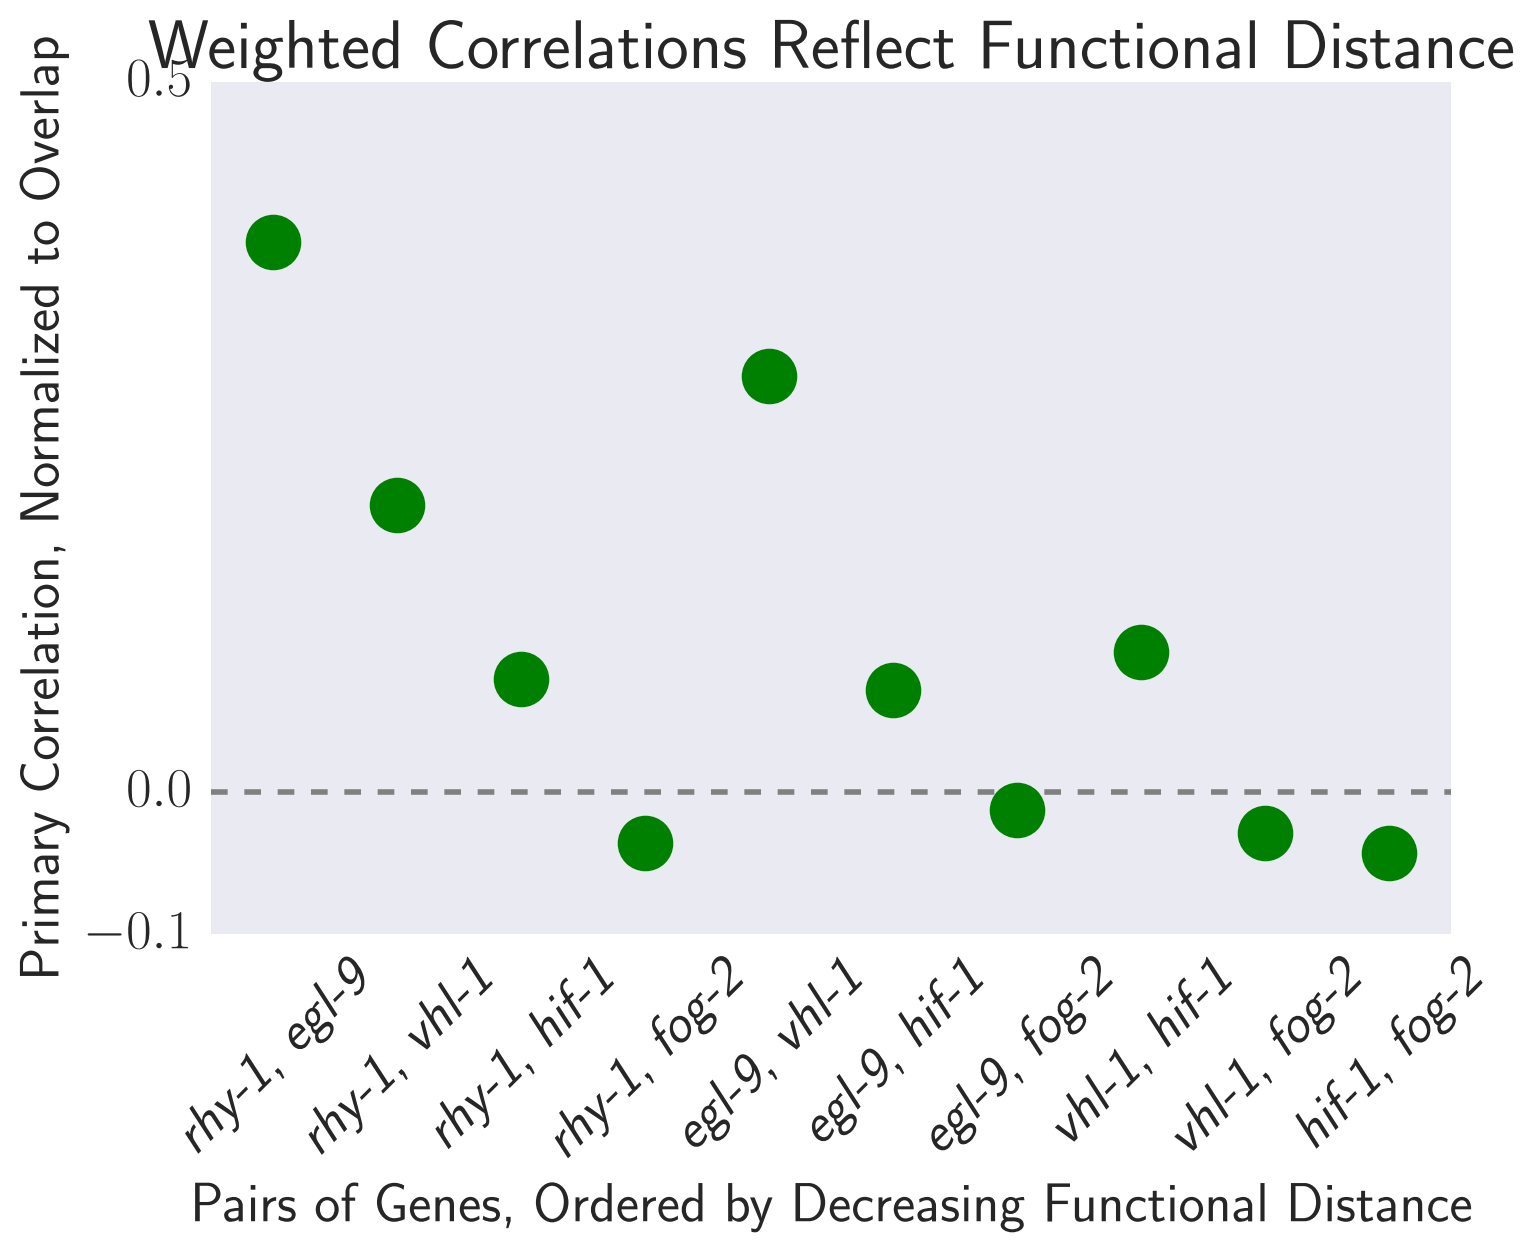

In [122]:
# sort_pairs = {'eb': 1,
#               'ed': 2,
#               'ec': 3,
#               'eg': 4,
#               'bd': 5,
#               'cb': 6,
#               'bg': 7,
#               'cd': 8,
#               'dg': 9,
#               'cg': 10
#              }
sort_pairs = {'eb': 1, 'be': 1,
              'ed': 2,'de': 2,
              'ec': 3,'ce': 3,
              'eg': 4,'ge': 4,
              'bd': 5,'db': 5,
              'cb': 6,'bc': 6,
              'bg': 7, 'gb': 7,
              'cd': 8,'dc': 8,
              'dg': 9,'gd': 9,
              'cg': 10,'gc': 10
             }

decode_pairs = {'eb': '\emph{rhy-1}, \emph{egl-9}', 'be': '\emph{rhy-1}, \emph{egl-9}',
              'ed': '\emph{rhy-1}, \emph{vhl-1}','de': '\emph{rhy-1}, \emph{vhl-1}',
              'ec': '\emph{rhy-1}, \emph{hif-1}','ce': '\emph{rhy-1}, \emph{hif-1}',
              'eg': '\emph{rhy-1}, \emph{fog-2}','ge': '\emph{rhy-1}, \emph{fog-2}',
              'bd': '\emph{egl-9}, \emph{vhl-1}','db': '\emph{egl-9}, \emph{vhl-1}',
              'cb': '\emph{egl-9}, \emph{hif-1}','bc': '\emph{egl-9}, \emph{hif-1}',
              'bg': '\emph{egl-9}, \emph{fog-2}', 'gb': '\emph{egl-9}, \emph{fog-2}',
              'cd': '\emph{vhl-1}, \emph{hif-1}','dc': '\emph{vhl-1}, \emph{hif-1}',
              'dg': '\emph{hif-1}, \emph{fog-2}','gd': '\emph{vhl-1}, \emph{fog-2}',
              'cg': '\emph{hif-1}, \emph{fog-2}','gc': '\emph{hif-1}, \emph{fog-2}'
             }


def sorted_pairs(x):
    key = x.pair
    if key in sort_pairs.keys():
        return sort_pairs[key]
    else:
        return np.nan
d.dropna(subset=['corrected'], inplace=True)
d['sort_pairs'] = d.pair.map(sort_pairs)
# d.head()
d.sort('sort_pairs', inplace=True)
d['genes'] = d.pair.map(decode_pairs)
# sns.stripplot(x='genes', y='corrected', hue= 'regression', data=d, size=20)
# sns.stripplot(x='genes', y='corrected', data=d[(d.regression=='secondary')], size=10, color='k')
sns.stripplot(x='genes', y='corrected', data=d[d.regression=='primary'], size=20, color='g')
plt.xticks(rotation=45, fontsize=20)
plt.yticks([-0.1, 0, 0.5], fontsize=20)
plt.axhline(0, lw=2, ls='--', color='gray')
# plt.xlabel('Pairs of Genes, Ordered by Decreasing Biochemical Distance')
# plt.ylabel('Primary Correlation, Normalized to Overlap')
# plt.title('Weighted Correlation Reflects Biochemical Distance')
pathify('Weighted Correlations Reflect Functional Distance',
        'Pairs of Genes, Ordered by Decreasing Functional Distance',
       'Primary Correlation, Normalized to Overlap')
plt.savefig('../output/weighted_corr_decreases_w_distance.pdf')

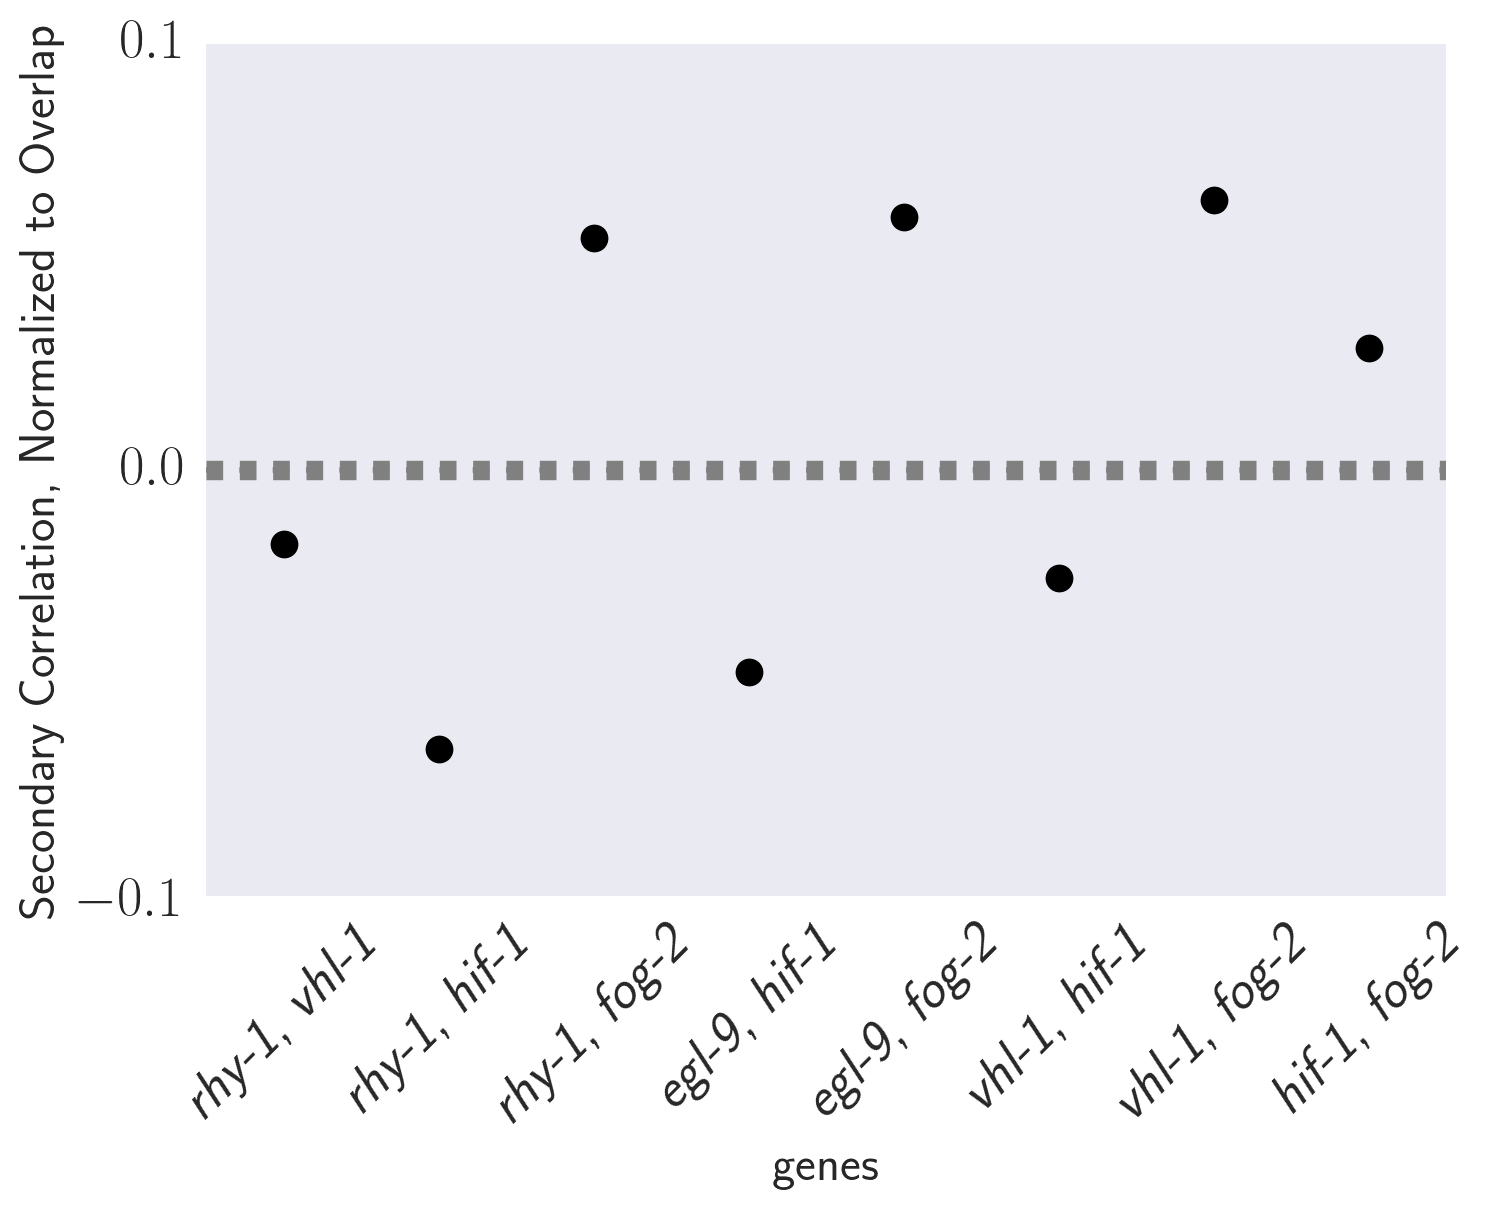

In [112]:
# sns.stripplot(x='genes', y='corrected', hue= 'regression', data=d, size=20)
sns.stripplot(x='genes', y='corrected', data=d[(d.regression=='secondary') & (d.different == 1)], size=10, color='k')
plt.axhline(0, ls='--', color='0.5')
plt.xticks(rotation=45, fontsize=20)
plt.yticks([-0.1, 0, 0.1], fontsize=20)
plt.axhline(0, lw=2, ls='--', color='gray')
# plt.xlabel('Pairs of Genes, Ordered by Decreasing Biochemical Distance')
plt.ylabel('Secondary Correlation, Normalized to Overlap')

It appears that 'C' and 'B' and 'C' and 'E' interact in both a positive and negative manner and both correlations are well supported by evidence. Intriguing!

# Double Mutant Analysis

With double mutants, the analysis gets slightly more complicated. Now we're getting into full pathways!

A first approach is to inspect the double mutants by Spearman correlation analysis to the single mutants that make them up. A quick visualization will show us any epistasis and the extent of it:

In [30]:
alfred = morgan.sturtevant('epistasis analysis')
alfred.epistasis_analysis(thomas)
alfred.epistasis_secondary(thomas, True)

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.4 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.6 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.6 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.6 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 2.2 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in

([<matplotlib.axis.YTick at 0x1a85d1e10>,
 <a list of 3 Text yticklabel objects>)

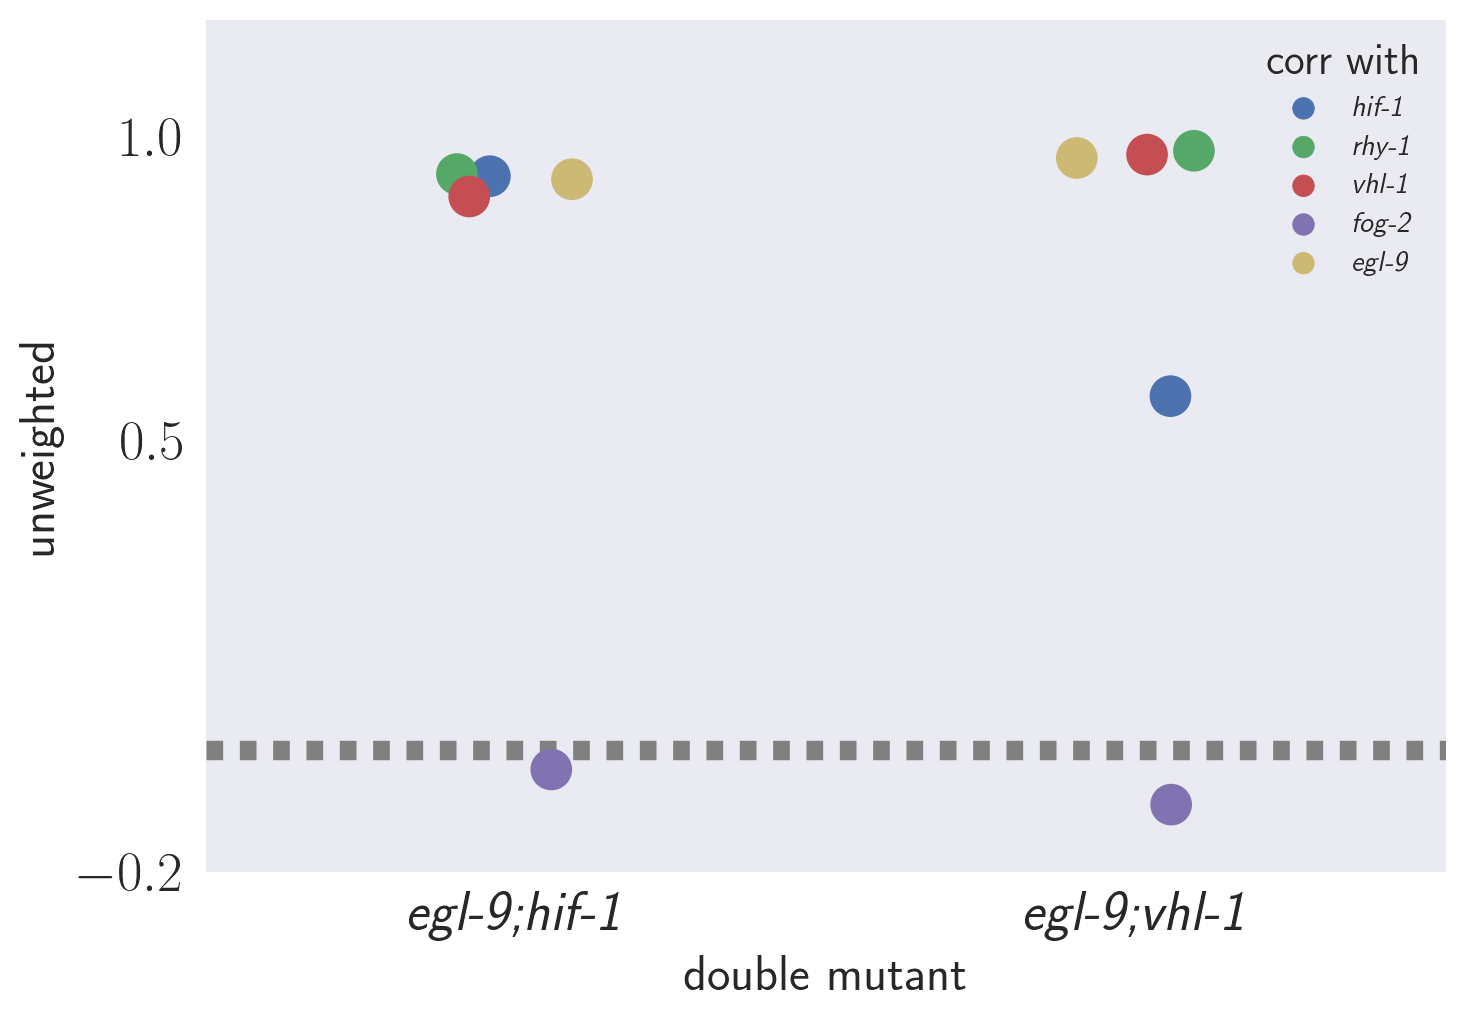

In [31]:
alfred.epistasis['unweighted'] = alfred.epistasis.correlation/alfred.epistasis.weights


alfred.epistasis['double mutant'] = alfred.epistasis.double_mutant.map(genotype_mapping)
alfred.epistasis['corr with'] = alfred.epistasis.corr_with.map(genotype_mapping)

sns.stripplot(x='double mutant', y='unweighted', hue='corr with', data=alfred.epistasis, size=15, jitter=True)
plt.xticks(fontsize=20)
plt.axhline(0, ls='--', color='0.5')
plt.yticks([-0.2, 0.5, 1], fontsize=20)

([<matplotlib.axis.YTick at 0x1b3be3c50>,
 <a list of 3 Text yticklabel objects>)

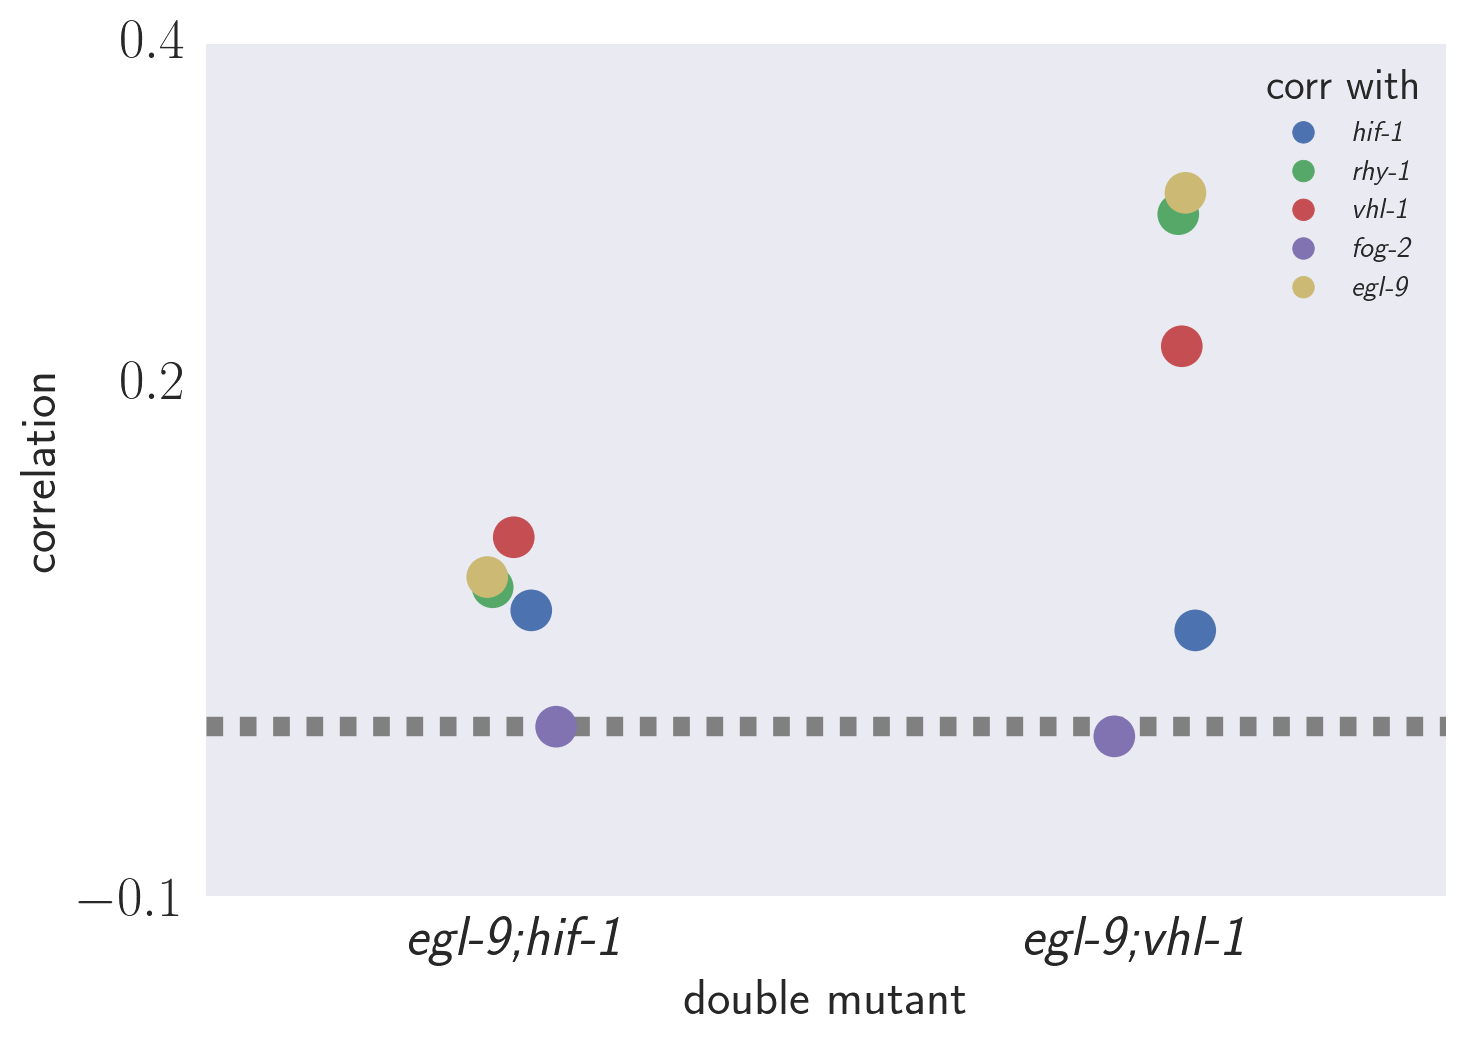

In [32]:
sns.stripplot(x='double mutant', y='correlation', hue='corr with', data=alfred.epistasis, size=15, jitter=True)
plt.xticks(fontsize=20)
plt.axhline(0, ls='--', color='0.5')
plt.yticks([-0.1, 0.2, 0.4], fontsize=20)

([<matplotlib.axis.YTick at 0x1b309e400>,
 <a list of 3 Text yticklabel objects>)

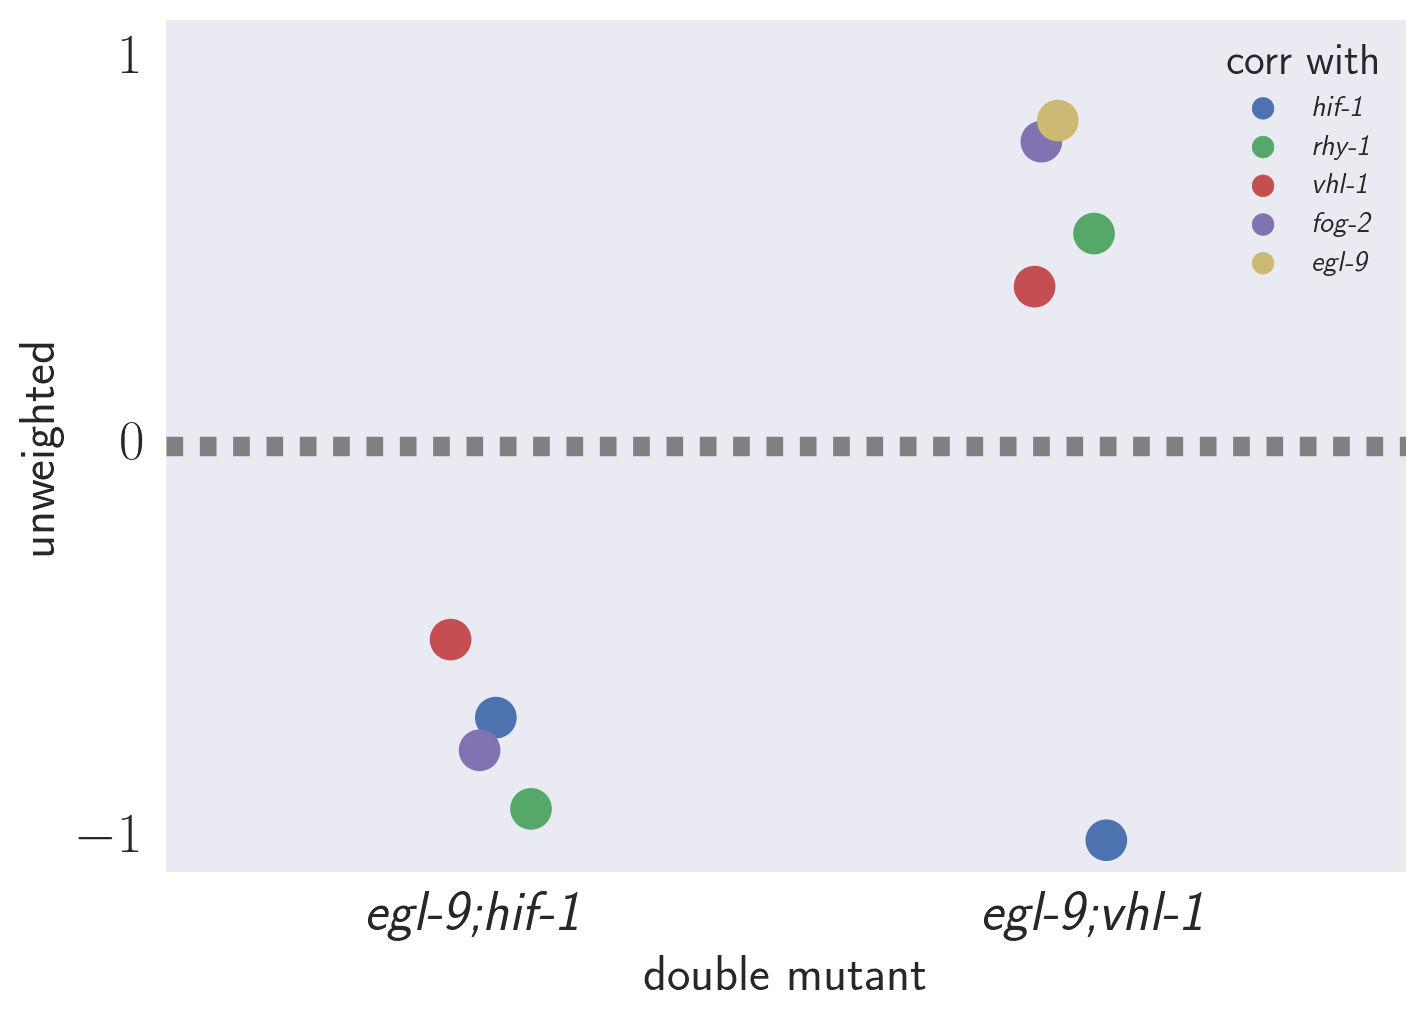

In [33]:
alfred.epistasis_secondary['unweighted'] = alfred.epistasis_secondary.correlation/alfred.epistasis_secondary.weights
alfred.epistasis_secondary['fractional corr'] = alfred.epistasis_secondary.correlation/alfred.epistasis.correlation.abs()

alfred.epistasis_secondary['double mutant'] = alfred.epistasis_secondary.double_mutant.map(genotype_mapping)
alfred.epistasis_secondary['corr with'] = alfred.epistasis_secondary.corr_with.map(genotype_mapping)


sns.stripplot(x='double mutant', y='unweighted', hue='corr with', data=alfred.epistasis_secondary,
              size=15, jitter=True)
plt.xticks(fontsize=20)
plt.ylim(-1.1, 1.1)
plt.axhline(0, ls='--', color='0.5')
plt.yticks([-1, 0, 1], fontsize=20)

([<matplotlib.axis.YTick at 0x1aeaf66d8>,
 <a list of 3 Text yticklabel objects>)

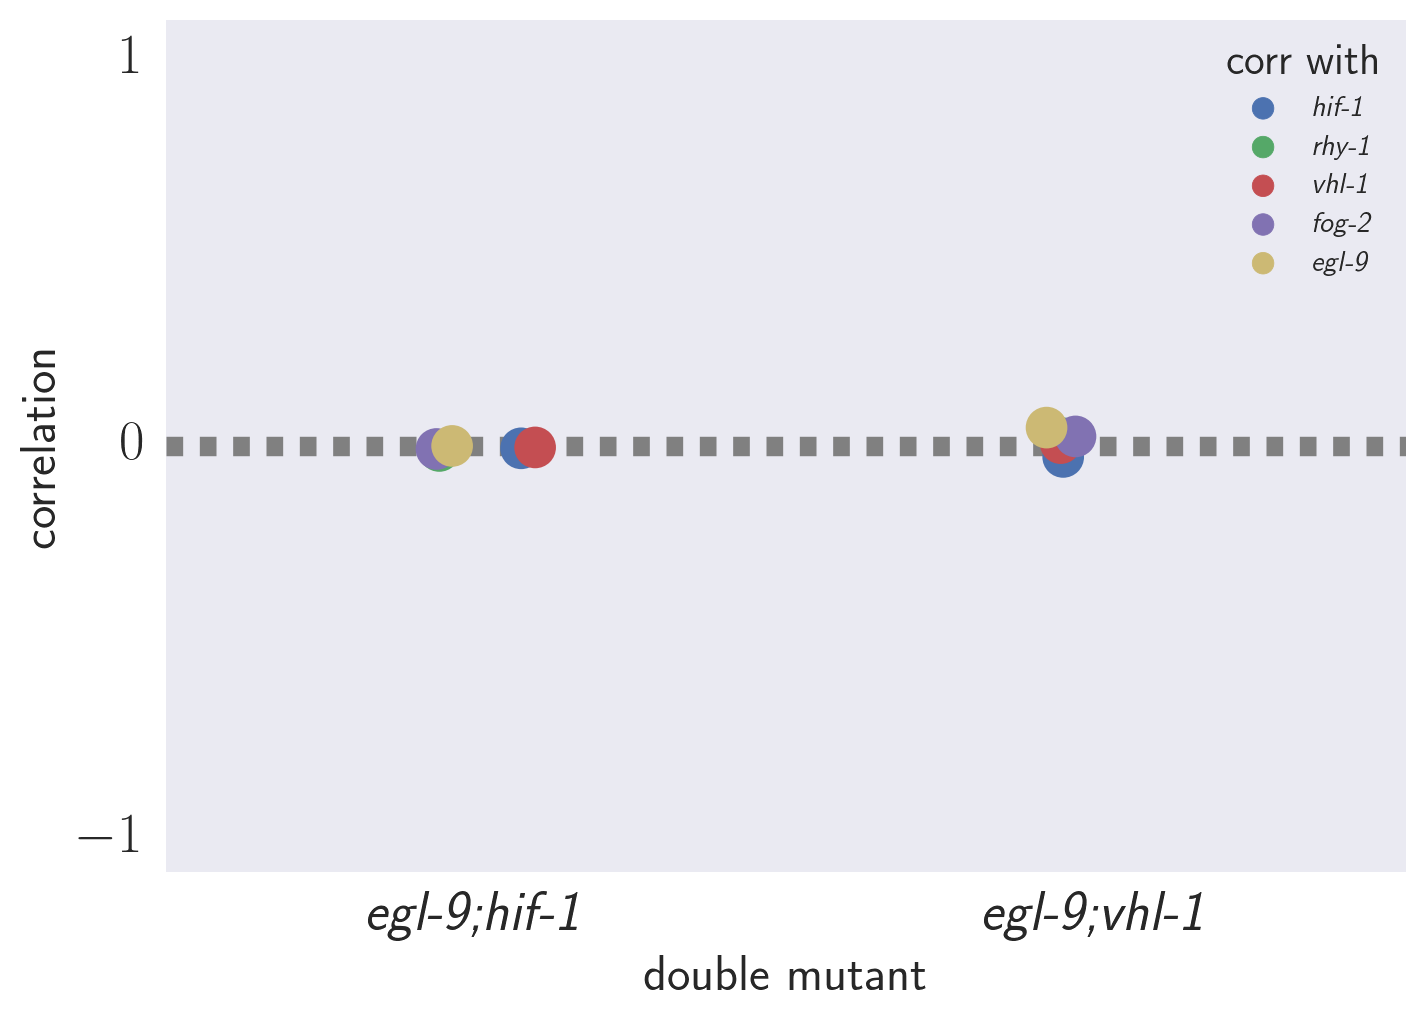

In [34]:
sns.stripplot(x='double mutant', y='correlation', hue='corr with', data=alfred.epistasis_secondary,
              size=15, jitter=True)
plt.xticks(fontsize=20)
plt.ylim(-1.1, 1.1)
plt.axhline(0, ls='--', color='0.5')
plt.yticks([-1, 0, 1], fontsize=20)

In [35]:
for key, value in thomas.double_muts.items():
    x = thomas.beta_filtered[key]
    y = thomas.beta_filtered[value[0]]
    z = thomas.beta_filtered[value[1]]
    
    x = x[x.qval < thomas.q]
    y = y[y.qval < thomas.q]
    z = z[z.qval < thomas.q]
    
    yANDz = len(y[y.target_id.isin(z)])
    yORz = len(y) + len(z)
    expected = yORz - yANDz
    
    pred1 = x[(x.target_id.isin(z.target_id))]
    pred2 = x[x.target_id.isin(y.target_id)]
    
    pred = len(list(set(pred1.target_id.tolist() + pred2.target_id.tolist())))
    
    print('Expected: ', expected)
    print('Observed: ', len(x))
    print('Predicted: ', pred)
    print('Observed/Expected: {0:.2g}'.format(len(x)/expected))
    print('Predicted/Expected: {0:.2g}'.format(pred/expected))
    print('Surprise factor: {0:.2g}'.format(pred/len(x)))

Expected:  2678
Observed:  362
Predicted:  247
Observed/Expected: 0.14
Predicted/Expected: 0.092
Surprise factor: 0.68
Expected:  2713
Observed:  2728
Predicted:  1604
Observed/Expected: 1
Predicted/Expected: 0.59
Surprise factor: 0.59


Double mutants:
$$
a = b^-d^-
$$

$$
f = b^-c^-
$$

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 2.2 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.4 sec

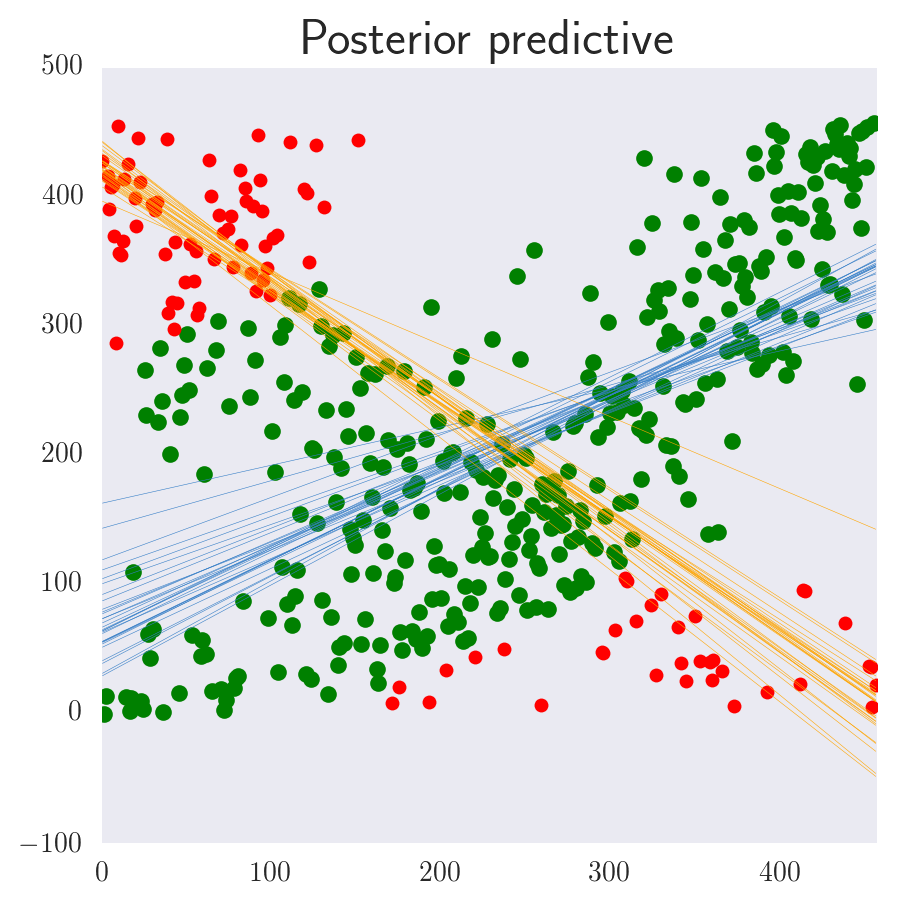

In [37]:
letters = ['a', 'c']

x = thomas.beta_filtered[letters[0]]
y = thomas.beta_filtered[letters[1]]

ovx = x[lind(x)]
ovy = y[lind(y) & y.target_id.isin(ovx.target_id)].copy()
ovx = x[lind(x) & x.target_id.isin(ovy.target_id)].copy()

xns = x[~x.target_id.isin(ovx.target_id)].copy()
yns = y[~y.target_id.isin(ovx.target_id)].copy()

def find_rank(df):
    """A function to find the rank values of a variable."""
    d = df.copy()
    d.sort_values('b', inplace=True)
    rank = np.linspace(0, len(d)-1, len(d))
    d['r'] = rank
    d.sort_values('target_id', inplace=True)
    return d

ovx = find_rank(ovx)
ovy = find_rank(ovy)

data = dict(x=ovx.r, y=ovy.r)

x = np.linspace(ovx.r.min(), ovx.r.max())
    
trace_robust = robust_regress(data)
plt.figure(figsize=(5, 5))

distribution =ovy.r - trace_robust.Intercept.mean() - ovx.r*trace_robust.x.mean()
mean = distribution.mean()
std = distribution.std()
distribution_inliers = distribution[np.abs(distribution - mean)/(trace_robust.x.std() 
                                                                 + trace_robust.Intercept.std()+ std) < 1]
distribution_outliers = distribution[np.abs(distribution - mean)/(trace_robust.x.std() 
                                                                 + trace_robust.Intercept.std()+ std) > 1]

outliers = ovy[ovy.r.isin(distribution_outliers + 
                          trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean())].target_id

data2 = dict(x=ovx[ovx.target_id.isin(outliers)].r, y=ovy[ovy.target_id.isin(outliers)].r)
trace_robust2 = robust_regress(data2)


yri = distribution_inliers + trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean()
yro = distribution_outliers + trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean()

plt.plot(ovx.r, yri, 'go', ms = 6)
plt.plot(ovx.r, yro, 'ro', ms = 5)
pm.glm.plot_posterior_predictive(trace_robust, eval=x, 
                                 label='posterior predictive regression lines',
                                 color='#357EC7')
pm.glm.plot_posterior_predictive(trace_robust2, eval=x, 
                                 label='posterior predictive regression lines',
                                 color='#FFA500')
plt.xlim(0, len(ovx))
# plt.legend()

if np.abs(trace_robust.x.mean()) > 0.6 and np.abs(trace_robust2.x.mean()) > 0.6:
    t1 = trace_robust.x.mean()/np.abs(trace_robust.x.mean())
    t2 = trace_robust2.x.mean()/np.abs(trace_robust2.x.mean())
    if t1 == -t2:
        print('Complex Regulation at Work')

In [38]:
trace_robust.x.mean()

0.57576438529289042

# Defining the Hypoxia Response

In [39]:
# find all the genes in the hypoxia response:
ovb = thomas.beta_filtered['b'].copy()
ovd = thomas.beta_filtered['d']
ove = thomas.beta_filtered['e']

ovb['d_qval'] = ovd.qval
ovb['e_qval'] = ove.qval

ovb['d_b'] = ovd.b
ovb['e_b'] = ove.b

# qvalue cutoff
ind1 = (ovb.qval < 0.1)
ind2 = (ovb.d_qval < 0.1)
ind3 = (ovb.e_qval < 0.1)

# make sure they all go in the same direction:
ind4 = (ovb.b*ovb.d_b > 0) & (ovb.b*ovb.e_b > 0) & (ovb.d_b*ovb.e_b >0)

hypoxia_genes = ovb[ind1 & ind2 & ind3 & ind4].copy()

In [40]:
len(hypoxia_genes)

538

In [41]:
tissue_df = tea.fetch_dictionary()
df_res, unused = tea.enrichment_analysis(hypoxia_genes.ens_gene, tissue_df, save=False)

Executing script

                               Tissue   Expected  Observed  \
0  anal depressor muscle WBbt:0004292  17.035573        33   

   Enrichment Fold Change   P value  Q value  
0                1.937123  0.000058   0.0151  


In [42]:
hypoxia_genes['avg_qval'] = (hypoxia_genes.qval + hypoxia_genes.e_qval + hypoxia_genes.d_qval)/3
hypoxia_genes['avg_b'] = (hypoxia_genes.b + hypoxia_genes.d_b + hypoxia_genes.e_b)/3
hypoxia_genes.sort_values(['avg_qval'], inplace=True)
hypoxia_genes.to_csv('../output/hypoxia_high_confidence.csv', index=False)

# The genes upregulated by egl-9 should be down in Hif-1.

However, egl-9 and hif-1 seem to have a positive primary relationship under normoxic conditions. Are the secondary genes associated with the hypoxia response?

In [69]:
# First, identify the genes that are outliers in the bc, ec response and intersect them.
if ('c', 'b') in barbara.correlated_genes.keys():
    key = ('c', 'b')
else:
    key = ('b', 'c')

if ('c', 'e') in barbara.correlated_genes.keys():
    key2 = ('c', 'e')
else:
    key2 = ('e', 'c')

print(key)
bc_in = barbara.correlated_genes[key]['corr']
ec_in = barbara.correlated_genes[key2]['corr']
bec_in = np.intersect1d(bc_in, ec_in)
print("""
There are {0} genes that are inliers in the BC intersection,
There are {1} genes that are inliers in the EC intersection,
and there are {2} genes in the BEC inliers intersection.
""".format(len(bc_in), len(ec_in), len(bec_in)))


bc = barbara.correlated_genes[key]['outliers'].target_id
ec = barbara.correlated_genes[key2]['outliers'].target_id
bec = np.intersect1d(bc, ec)
print("""
There are {0} genes that are outliers in the BC intersection,
There are {1} genes that are outliers in the EC intersection,
and there are {2} genes in the BEC outlier intersection.
""".format(len(bc), len(ec), len(bec)))

print(
"""
{0:.2g} of the genes in the BEC intersection are outliers
""".format(len(bec)/(len(bec) + len(bec_in)))
)

('c', 'b')

There are 251 genes that are inliers in the BC intersection,
There are 313 genes that are inliers in the EC intersection,
and there are 185 genes in the BEC inliers intersection.


There are 73 genes that are outliers in the BC intersection,
There are 87 genes that are outliers in the EC intersection,
and there are 48 genes in the BEC outlier intersection.


0.21 of the genes in the BEC intersection are outliers



In [70]:
intersection = hypoxia_genes[hypoxia_genes.target_id.isin(bec)].ext_gene.unique()
print(
"""
There are {} genes from the BEC intersection in the hypoxia set!
""".format(len(intersection))
)



There are 20 genes from the BEC intersection in the hypoxia set!



In [71]:
q = 0.1
L = thomas.beta_filtered['a'].shape[0] # total genes measured for any experiment

p = stats.hypergeom.sf(len(intersection), L, len(bec), len(hypoxia_genes))

if p < 10**-3:
    print(
"""
This result is statistically significant, with p-value = {0:.2g}
""".format(p)
    )


This result is statistically significant, with p-value = 9.1e-17



In fact, it does seem that hypoxia related genes are under control of *hif-1* under normoxic conditions, and that knocking *hif-1* out in a normoxic animal causes changes in this gene set. However, this is not the PRIMARY role of *hif-1* under physiologic conditions

In [72]:
intersection

array(['R08E5.3', 'pck-1', 'dod-24', 'fat-7', 'Y37A1B.5', 'pud-3', 'mct-3',
       'abhd-3.2', 'trpp-12', 'nit-1', 'F09C8.1', 'K01C8.1', 'ZK742.3',
       'C50B6.7', 'D1086.3', 'cyp-14A2', 'F11D5.7', 'dnj-28', 'cbl-1',
       'nuc-1'], dtype=object)

In [73]:
temp = thomas.beta_filtered['c']
temp[temp.target_id.isin(intersection)].qval.values

array([  8.51323945e-10,   4.30236412e-10,   3.96176818e-05,
         7.56965077e-06,   5.17637513e-06,   1.50345089e-03])

Unfortunately, none of them are immediately associated with the hypoxia pathway, but a number of these are stress response genes! Thankfully, the q-values are also reasonably low for most of these genes. We're all good. 

# Tissue and Phenotype Enrichment Analyses:

In [74]:
thomas.enrichment_analysis(x='ens_gene', analysis='tissue')

Executing script

Executing script

Executing script

Executing script

Executing script

Executing script

Executing script



In [75]:
df_phe, unused = tea.enrichment_analysis(hypoxia_genes.ens_gene.unique(), phenotype_df, show=False, save=False)
df_phe.head()

Executing script



,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
58,vulval cell induction reduced WBPhenotype:0000219,32.518960,79,2.429352,4.478846e-15,1.039092e-12
5,mid larval arrest WBPhenotype:0001019,14.484290,48,3.313935,2.404677e-14,2.789426e-12
34,serotonin response variant WBPhenotype:0001232,8.577465,36,4.197044,2.900573e-14,2.789426e-12
52,intestinal cell development variant WBPhenotyp...,4.712893,25,5.304598,7.942378e-13,4.606579e-11
56,RNA expression variant WBPhenotype:0000113,22.967497,58,2.525308,7.424515e-12,3.444975e-10


# Quality Control

Load up the hypoxia gold standard Carmie gave me. These genes are expected to go up in everything except in Hif-1. 

By this point, I have solved the network, I guessed which gene was Hif-1 and I have been told the identities of the genes. 

C = Hif-1  
B = egl-9  
D = vhl-1  
E = rhy-1  

nhr-57 is an important gene for hypoxia. WBID is WBGene00003647

In [76]:
hypoxia_gold = pd.read_csv('../input/hypoxia_gold_standard.csv', sep=',')

In [77]:
# Figure out how many hits we get and if the pvalue is significant!
for sm in thomas.single_mutants:
    df = thomas.beta_filtered[sm]
    ind = (genpy.find(df, hypoxia_gold.WBIDS, col='ens_gene'))
    found = df[ind & (df.qval < 0.1)]
    sig = df[df.qval < 0.1]
    pval = stats.hypergeom.sf(len(found), len(df), len(hypoxia_gold), len(sig))
    print('genotype: ', sm)
    print('found: ', len(found), '      Mean b: {0:.2g}'.format(found.b.mean()))
    print('pval: {0:.2g}'.format(pval))
    
    
    print('Maximum change was:')
    print(found[found.b == found.b.max()].ext_gene.values[0])
    print(np.exp(found[found.b == found.b.max()].b.values)[0], ' fold change')
    if 'WBGene00003647' in found.ens_gene.values:
        nhr57 = np.exp(found[found.ens_gene == 'WBGene00003647'].b.values[0])
        print('nhr-57 is in', sm, 'and its fold change was {0:.2g}'.format(nhr57))
    
    print('----------')

genotype:  c
found:  1       Mean b: 0.46
pval: 0.46
Maximum change was:
rhy-1
1.58146039596  fold change
----------
genotype:  e
found:  10       Mean b: 2.4
pval: 0.00062
Maximum change was:
nhr-57
46.2035111021  fold change
nhr-57 is in e and its fold change was 46
----------
genotype:  d
found:  8       Mean b: 2.1
pval: 1e-05
Maximum change was:
dod-3
43.9856731422  fold change
nhr-57 is in d and its fold change was 7.1
----------
genotype:  g
found:  4       Mean b: -1.5
pval: 0.12
Maximum change was:
Y44A6C.1
0.626140635327  fold change
----------
genotype:  b
found:  9       Mean b: 2.6
pval: 0.00022
Maximum change was:
oac-54
65.3416617632  fold change
nhr-57 is in b and its fold change was 63
----------


rhy-1 hif-1
vhl-1 hif-1
vhl-1 rhy-1
fog-2 hif-1
fog-2 rhy-1
fog-2 vhl-1
egl-9 hif-1
egl-9 rhy-1
egl-9 vhl-1
egl-9 fog-2
[1.191404251206412, -0.64093131004987736, 1.0795335844763039, 1.4860503186500909, -0.53619870395266434, 5.8153556989378421, 3.0376913945347934, -0.18930948817361848, -0.4239479969403907, 4.3980120150387609]


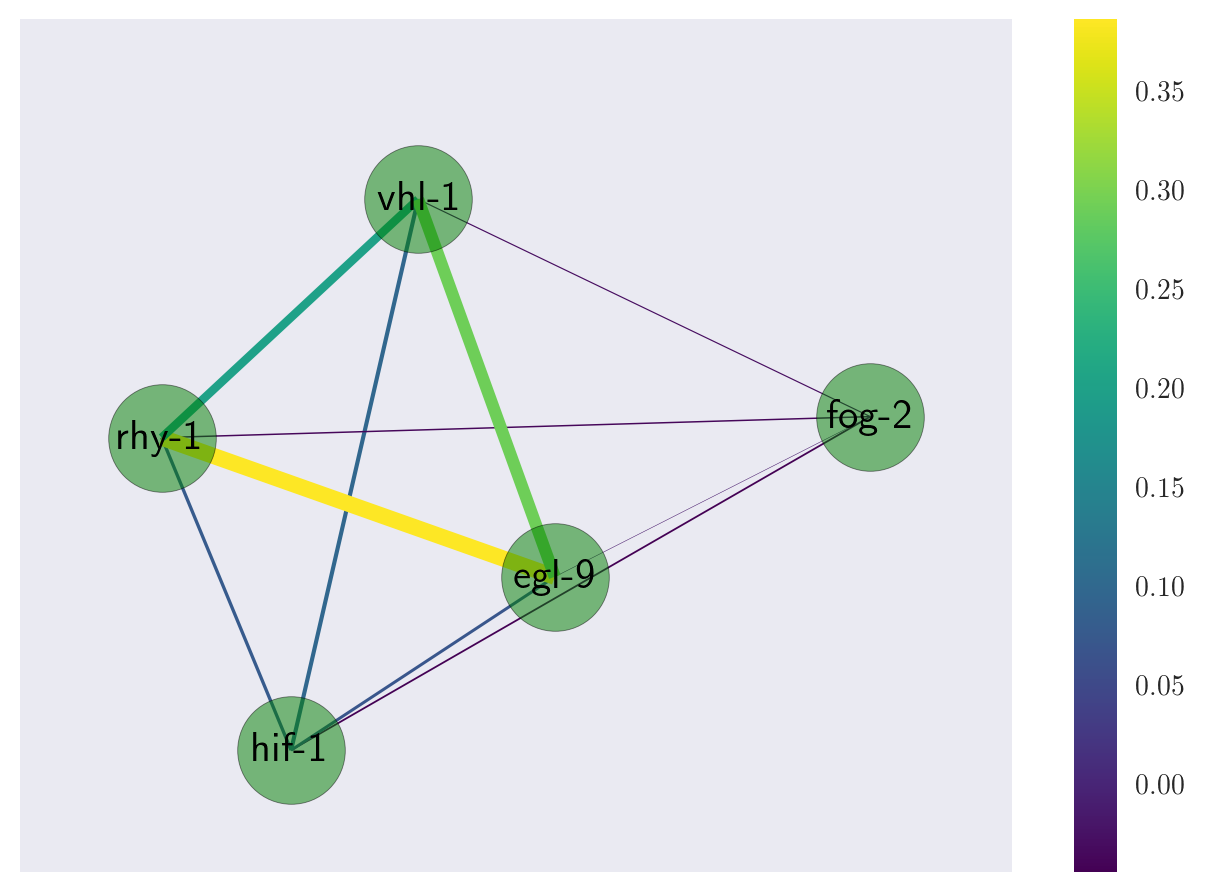

In [78]:
G=nx.Graph()

mutant_dict = {'b': 'egl-9',
               'c': 'hif-1',
               'e': 'rhy-1',
               'd': 'vhl-1',
               'g': 'fog-2'
              }

# for i in single_mutants:
#     G.add_node(i)

for i, key in enumerate(thomas.single_mutants):
    for j, key2 in enumerate(thomas.single_mutants):
        df = d
        r = d[(d.variable == key) & (d.corr_with == key2) &
              (d.regression == 'primary')].corrected.values
        if r:
            G.add_edge(mutant_dict[key], mutant_dict[key2], weight=r[0])
            print(mutant_dict[key], mutant_dict[key2])


elarge=[(u,v) for (u,v,d) in G.edges(data=True)]
width=[15*d['weight'] for (u,v,d) in G.edges(data=True)]
print(width)
weights=[d['weight'] for (u,v,d) in G.edges(data=True)]
# edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

fig, ax = plt.subplots()

pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='g', alpha=.5)

# edges
edges = nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=width, edge_color=weights,
                       edge_cmap=plt.cm.viridis)
# edges = nx.draw_networkx_edges(G, pos, edgelist=elarge,
#                        width=width)

# labels
nx.draw_networkx_labels(G, pos, font_size=15, font_family='sans-serif')

fig.colorbar(edges)

# plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.savefig("../output/weighted_graph.pdf") # save as png
plt.show() # display

# An *in silico* qPCR experiment:

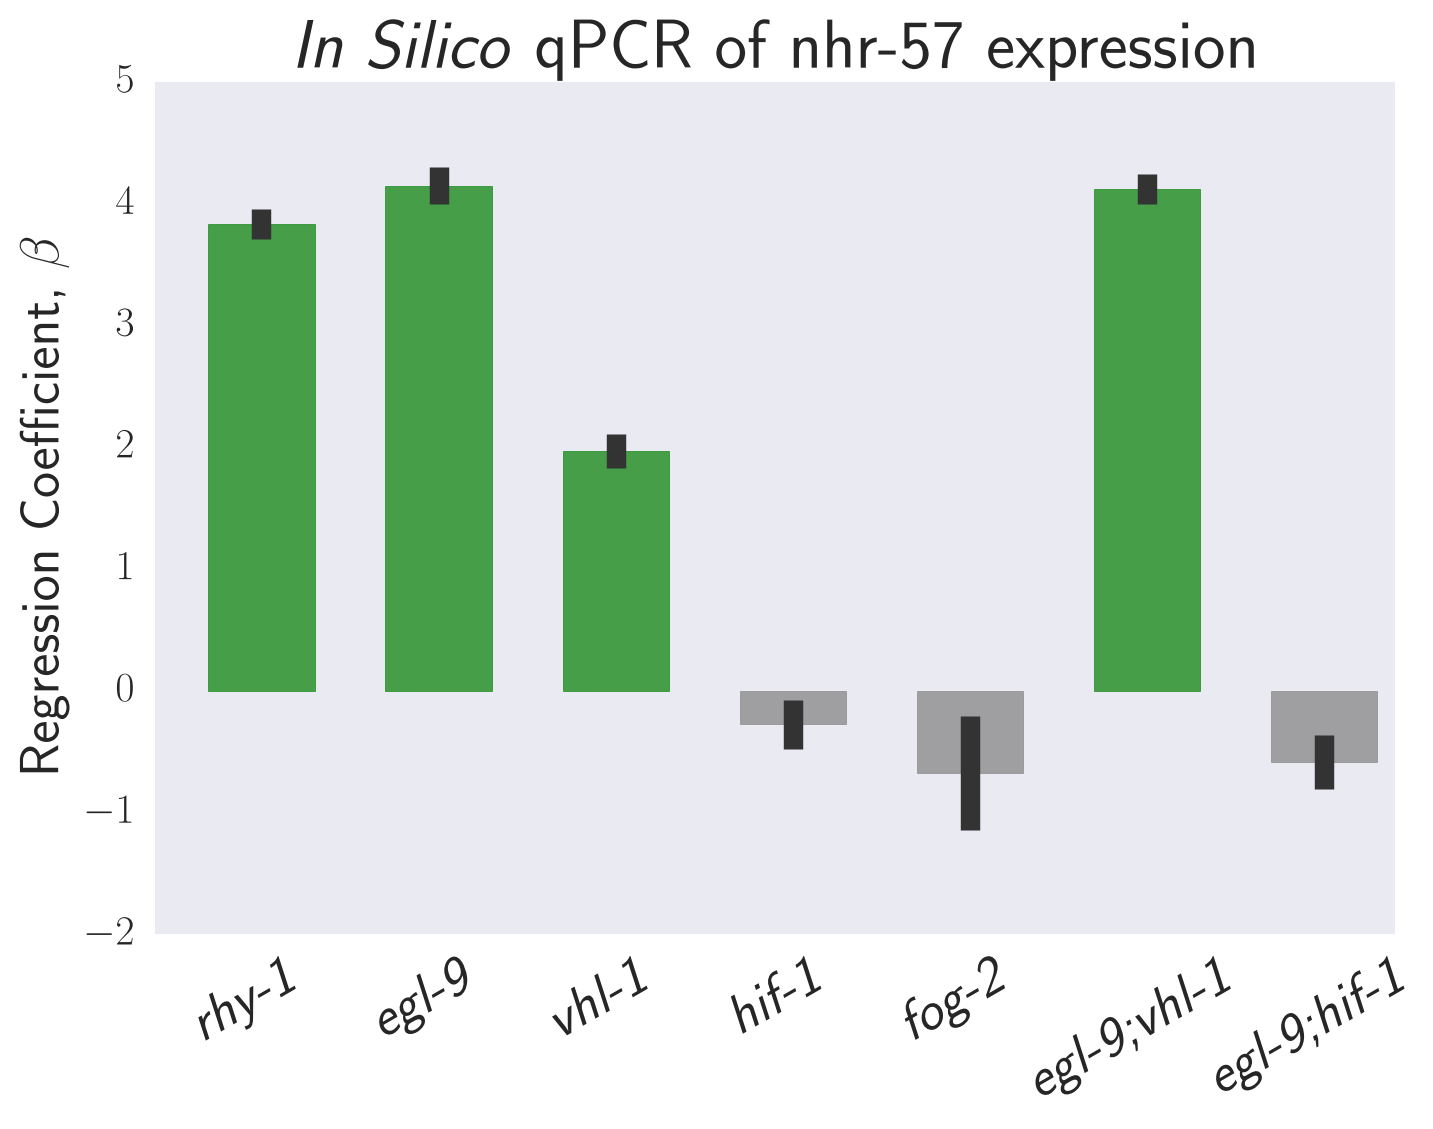

In [79]:
# nhr-57
nhr = 'WBGene00003647'
data = np.array([])
sorter = {'a': 6,
          'f': 7,
          'b': 2,
          'c': 4,
          'd':3,
          'e': 1,
          'g': 5
         }

g = []
for genotype, df in thomas.beta_filtered.items():
    x = genotype_mapping[genotype]
    y = df[(df.ens_gene == nhr)][['b', 'se_b', 'qval']].values
    if len(data) == 0:
        data = y
    else:
        data = np.vstack((data, y))
    g += [genotype]

d = pd.DataFrame(data, columns=['b', 'se_b', 'qval'])
d['code'] = g
d['genotype'] = d.code.map(genotype_mapping)
d['order'] = d.code.map(sorter)
d.sort_values('order', inplace=True)

# a qPCR barplot
temp = d#[(d.code != 'a') &( d.code != 'f')]

index = np.linspace(0, temp.shape[0]-1, temp.shape[0])
bar_width = 0.6
alpha = 0.7
error_config = {'ecolor': '0.2'}
barlist = plt.bar(index+0.3, temp.b.values, bar_width, alpha=alpha, yerr=temp.se_b, error_kw=error_config)
for i, genotype in enumerate(temp.genotype):
    if temp[temp.genotype == genotype].qval.values[0] < 0.1:
        barlist[i].set_color('g')
    else:
        barlist[i].set_color('0.5')

plt.xticks(index + 1/2, temp.genotype, rotation=30, fontsize=20)
plt.yticks(fontsize=15)

pathify(r'\emph{In Silico} qPCR of nhr-57 expression', '', r'Regression Coefficient, $\beta$' )
# plt.ylabel('Regression Coefficient', fontsize=20).set_path_effects([path_effects.Normal()])
# plt.title(r'\emph{In Silico} qPCR of nhr-57 expression', fontsize=25).set_path_effects([path_effects.Normal()])
plt.savefig('../output/nhr57qPCR.pdf', bbox_inches='tight')

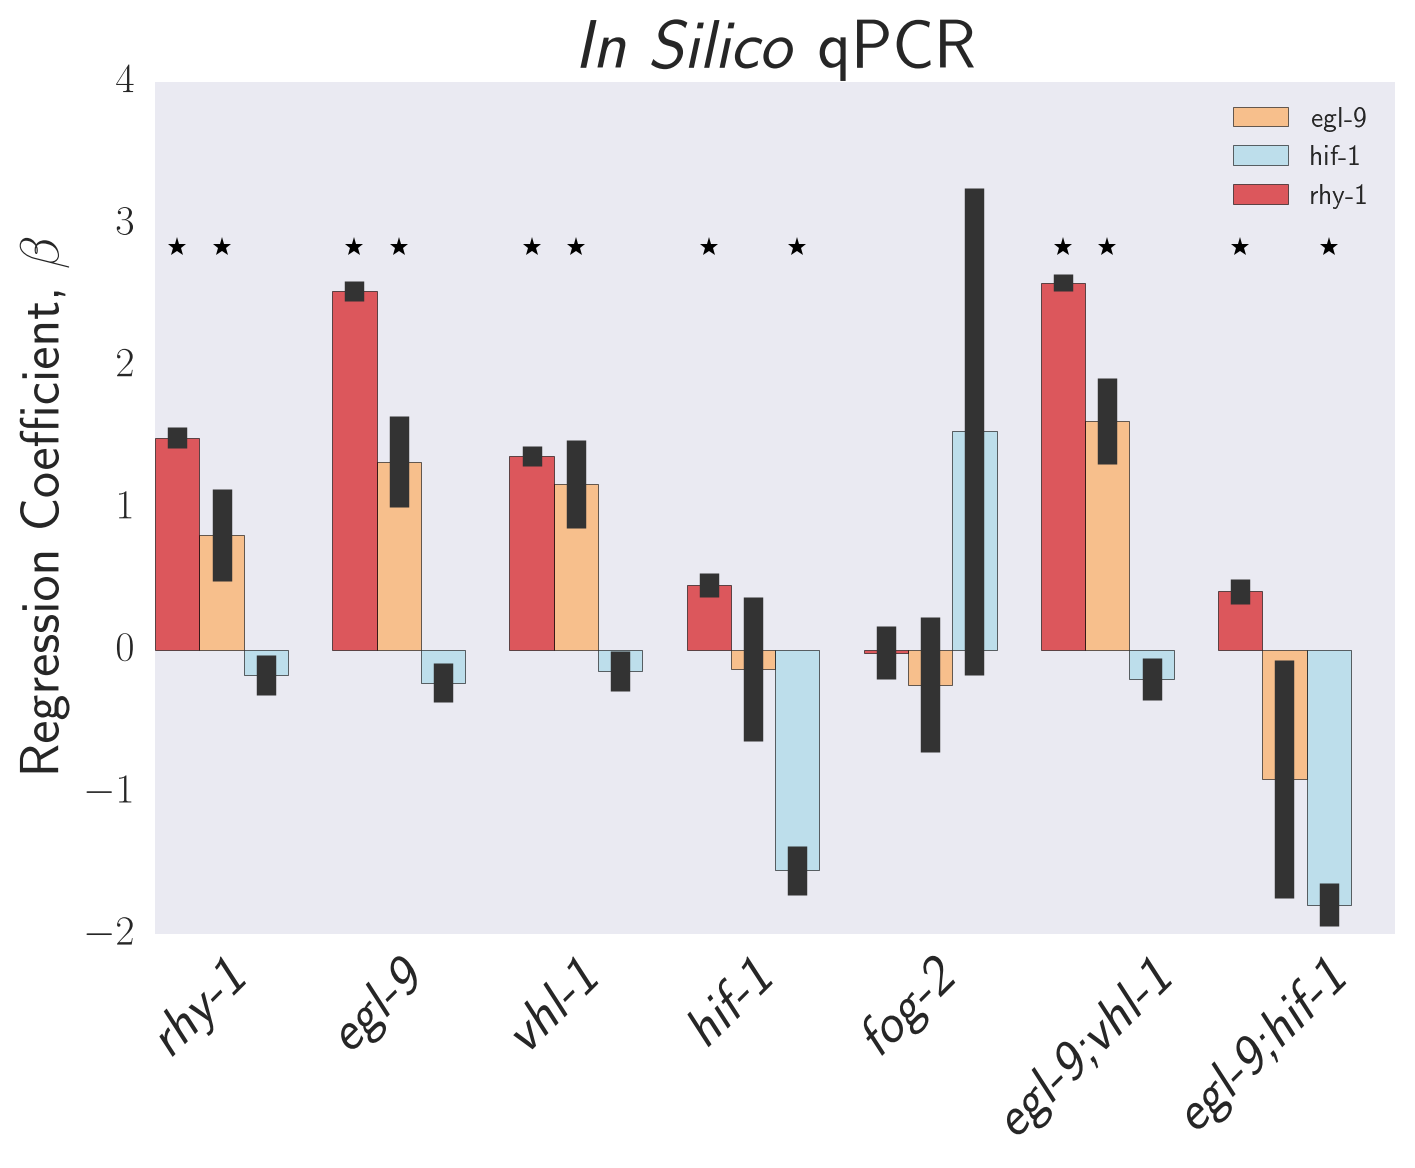

In [80]:
x = ['WBGene00001851',
     'WBGene00012324',
     'WBGene00001178',
     'WBGene00006922']

# run the experiment!
g = []
data = np.array([])
i = 0
for genotype, df in thomas.beta.items():
    for j, xi in enumerate(x):
        geno = genotype_mapping[genotype]
        y = df[(df.ens_gene == xi)][['ext_gene','b', 'se_b', 'qval']].values
        if len(y) == 0:
            continue
        # hif has two isoforms, so take F38A6.3c
        if y.shape[0] > 1:
            y = df[(df.target_id == 'F38A6.3c')][['ext_gene','b', 'se_b', 'qval']].values
        if len(data) == 0:
            data = y
        else:
            data = np.vstack((data, y))
        g += [genotype]
    i += 1

d = pd.DataFrame(data, columns=['ext_gene', 'b', 'se_b', 'qval'])
d['code'] = g
d['genotype'] = d.code.map(genotype_mapping)
d['order'] = d.code.map(sorter)
d.sort_values('order', inplace=True)
d.reset_index(inplace=True)    

# a qPCR barplot
temp = d
index = np.linspace(0, temp.genotype.unique().shape[0]-1, temp.genotype.unique().shape[0])
bar_width = 0.25
alpha = 0.7
error_config = {'ecolor': '0.2'}

plotting = {'rhy-1': 0,
            'egl-9': 1,
            'hif-1': 2,
            }

color = {'rhy-1': "#d7191c",
        'egl-9': '#fdae61',
        'hif-1': '#abd9e9',
        }

grouped = temp.groupby('ext_gene')
for name, group in grouped:
    add = plotting[name]*bar_width
    barlist = plt.bar(index + add, group.b.values, bar_width, alpha=alpha,
                      yerr=group.se_b, error_kw=error_config, label=name,
                      color=color[name])
    sig = group.qval < 0.1
    k = group[sig].order -1 
    plt.plot(k + add + bar_width/2, np.repeat(temp.b.max() + 0.25, len(k)), r'*', color='k')

plt.xticks(index + bar_width, temp.genotype.unique(), rotation=45, fontsize=20)
plt.yticks(fontsize=15)
# plt.ylabel('Regression Coefficient', fontsize=20)
# plt.title(r'\emph{In Silico} qPCR', fontsize=25)
pathify(r'\emph{In Silico} qPCR', '', r'Regression Coefficient, $\beta$')
plt.legend()
plt.savefig('../output/pathwaygenes_qPCR.pdf', bbox_inches='tight')

# Define the Absolute Gold Set 
by Finding the Intersection Between the Double Mutant that is Constitutively Hypoxic and the single mutants that are also hypoxic

In [81]:
# gene should be in double constitutive:
temp = thomas.beta_filtered['a']
temp = temp[temp.qval < 0.1]
temp = temp[temp.target_id.isin(hypoxia_genes.target_id)]

# should not be in the genes that go up in hif-1 mutants:
nothif1 = thomas.beta_filtered['f']
nothif1 = nothif1[(nothif1.qval < 0.1) & (nothif1.b > 0)]
nothif2 = thomas.beta_filtered['c']
nothif2 = nothif2[(nothif2.qval < 0.1) & (nothif2.b > 0)]

ind1 = ~temp.target_id.isin(nothif1.target_id)
ind2 = ~temp.target_id.isin(nothif2.target_id)
temp = temp[(ind1) & (ind2)]
temp.shape

(401, 14)

In [82]:
temp['b_sm'] = hypoxia_genes.b
temp['qval_avg_sm'] = hypoxia_genes.avg_qval
temp['avg_b_sm'] = hypoxia_genes.avg_b

gold = temp[temp.b*temp.b_sm > 0]

In [83]:
gold.head()

,Unnamed: 0,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,ens_gene,ext_gene,b_sm,qval_avg_sm,avg_b_sm
77,2189,B0205.11,1.197772e-03,1.011349e-02,-0.293363,0.090560,5.537161,0.035222,0.004145,0.007610,0.008157,0.008157,WBGene00015025,mrpl-9,-0.345981,0.009488,-0.386837
82,762,B0205.7,5.986565e-08,1.452096e-06,-0.309054,0.057029,7.116642,0.029773,0.000860,0.000539,0.004019,0.004019,WBGene00002191,kin-3,-0.241362,0.011786,-0.262453
90,207,B0213.14,5.350072e-20,4.777071e-18,-0.974203,0.106392,5.458336,0.298304,0.004436,0.012543,0.008620,0.012543,WBGene00015043,cyp-34A8,-0.742839,0.002248,-0.544331
98,469,B0222.3,8.161378e-11,3.216349e-09,2.068628,0.318368,3.862477,1.405396,0.038460,0.113578,0.049172,0.113578,WBGene00015055,pitr-3,2.284886,0.030816,1.872164
103,1888,B0222.9,4.021802e-04,3.937234e-03,-0.754746,0.213286,4.925601,0.225482,0.006974,0.061262,0.013756,0.061262,WBGene00015057,gad-3,-1.129194,0.004484,-0.899733


In [84]:
ind = (genpy.find(hypoxia_genes, hypoxia_gold.WBIDS, col='ens_gene'))
found = hypoxia_genes[ind].ens_gene.unique()
sig = len(hypoxia_genes)
pval = stats.hypergeom.sf(len(found), len(thomas.beta_filtered['a']), len(hypoxia_gold), sig)    

In [85]:
pval

1.7215496732098234e-05

In [86]:
hypoxia_genes[ind].ext_gene.unique()

array(['rhy-1', 'nhr-57', 'phy-2', 'oac-54', 'cysl-2', 'egl-9'], dtype=object)

In [87]:
len(gold)

401

In [88]:
gold[gold.target_id.isin(tf_df.target_id)][['ext_gene', 'qval_avg_sm', 'avg_b_sm']]

,ext_gene,qval_avg_sm,avg_b_sm
508,C02F12.5,1.026012e-02,1.253357
3638,F17C11.1,1.275576e-02,0.796695
8146,nhr-57,6.147653e-43,3.314348
9262,nhr-135,1.277433e-02,0.785916
9362,W02D7.6,3.196308e-03,0.331905


# Hypoxia Positive Interaction

In [89]:
# find all the genes in the hypoxia response:
ovb = thomas.beta_filtered['b'].copy()
ovd = thomas.beta_filtered['d']
ove = thomas.beta_filtered['e']
ovc = thomas.beta_filtered['c']
ova = thomas.beta_filtered['a']

ovb['d_qval'] = ovd.qval
ovb['e_qval'] = ove.qval
ovb['c_qval'] = ovc.qval
# ovb['a_qval'] = ova.qval

ovb['d_b'] = ovd.b
ovb['e_b'] = ove.b
ovb['c_b'] = ovc.b
# ovb['a_b'] = ova.b

# qvalue cutoff
ind1 = (ovb.qval < 0.1)
# ind2 = (ovb.d_qval < 0.1)
ind3 = (ovb.e_qval < 0.1)
ind4 = (ovb.c_qval < 0.1)
# ind5 = (ovb.a_qval < 0.1)

i1 = ind1 & ind2 & ind3 & ind4 #& ind5

# make sure they all go in the same direction:
# ind5 = (ovb.b*ovb.d_b > 0) & (ovb.b*ovb.e_b > 0) & (ovb.d_b*ovb.e_b >0)
# ind6 = (ovb.b*ovb.c_b > 0) & (ovb.c_b*ovb.e_b > 0) & (ovb.d_b*ovb.c_b >0)

ind5 =  (ovb.b*ovb.e_b > 0)
ind6 = (ovb.b*ovb.c_b > 0) & (ovb.c_b*ovb.e_b > 0)
# ind7 = (ovb.b*ovb.a_b > 0) & (ovb.c_b*ovb.a_b > 0) & (ovb.e_b*ovb.a_b > 0)

i2 = ind5 & ind6 #& ind7

# novel_response = ovb[ind1 & ind2 & ind3 & ind4 & ind5 & ind6].copy()
novel_response = ovb[i1 & i2].copy()


novel_response['avg_qval'] = (ovb.qval + ovb.d_qval + ovb.e_qval + ovb.c_qval)/4
novel_response['avg_b'] = (ovb.b + ovb.d_b + ovb.e_b + ovb.c_b)/4
novel_response.sort_values(['avg_qval'], inplace=True)

In [90]:
len(novel_response.ens_gene.unique())

44

# Searching for a TF that is activated by both egl-9 and hif-1
And possibly regulates rhy-1 as a result

In [91]:
# Figure out how many hits we get and if the pvalue is significant!
tfs = {}
for sm in thomas.single_mutants:
    df = thomas.beta_filtered[sm]
    ind = (genpy.find(df, tf_df.target_id, col='target_id'))
    found = df[ind & (df.qval < 0.1)]
    sig = df[df.qval < 0.1]
    pval = stats.hypergeom.sf(len(found), len(df), len(hypoxia_gold), len(sig))
    print('genotype: ', sm)
    print('found: ', len(found), '      Mean b: {0:.2g}'.format(found.b.mean()))
    print('pval: {0:.2g}'.format(pval))
    tfs[sm] = found.copy()
        
    print('----------')

genotype:  c
found:  23       Mean b: 0.03
pval: 0
----------
genotype:  e
found:  34       Mean b: 0.49
pval: 0
----------
genotype:  d
found:  15       Mean b: 0.53
pval: 1.6e-14
----------
genotype:  g
found:  33       Mean b: 0.13
pval: 0
----------
genotype:  b
found:  18       Mean b: 0.59
pval: 8e-15
----------


In [92]:
def add_b(x):
    vals = tfs['c'][tfs['c'].target_id == x]
    if len(vals):
        return vals.b.values[0]
    else:
        return np.nan

temp = tfs['b']
temp['b_c'] = temp.target_id.apply(add_b)

In [93]:
temp[(temp.b_c < 0) & (temp.b < 0)][['ext_gene','b_c','b', 'qval']]

,ext_gene,b_c,b,qval
5201,mxl-3,-0.920322,-0.770323,0.000003


In [94]:
# mxl-3 should be down in the egl, hif double:
temp = thomas.beta_filtered['f']
temp[(temp.ext_gene == 'mxl-3')][['ext_gene', 'b', 'qval']]

,ext_gene,b,qval
5201,mxl-3,-0.73485,0.083105


In [95]:
temp = thomas.beta_filtered['a']
temp[(temp.ext_gene == 'mxl-3')][['ext_gene', 'b', 'qval']]

,ext_gene,b,qval
5201,mxl-3,-0.294871,0.049373


In [96]:
temp = thomas.beta_filtered['e']
temp[(temp.ext_gene == 'mxl-3')][['ext_gene', 'b', 'qval']]

,ext_gene,b,qval
5201,mxl-3,-0.329363,0.031791


In [97]:
temp = thomas.beta_filtered['d']
temp[(temp.ext_gene == 'mxl-3')][['ext_gene', 'b', 'qval']]

,ext_gene,b,qval
5201,mxl-3,-0.370859,0.251539


In [98]:
# hypoxia_genes.to_csv('../hypoxia_genes.csv',index=False)
from bokeh.resources import CDN
from bokeh.embed import file_html
from IPython.core.display import HTML

# Use Bokeh chart to make plot
hypoxia_genes['logq'] = -np.log(hypoxia_genes.avg_qval)
hypoxia_genes['logq'] = hypoxia_genes['logq'].astype(np.float64)
hypoxia_genes['avg_b'].astype(np.float64)
hypoxia_genes.logq.fillna(700, inplace=True)
hypoxia_genes.logq.replace([np.inf], 700, inplace=True)
hypoxia_genes.logq.replace([-np.inf], 0, inplace=True)

hypoxia_genes.b.replace([np.inf], 6, inplace=True)
hypoxia_genes.b.replace([-np.inf], -6, inplace=True)
hypoxia_genes.dropna(inplace=True)

# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene')]

# Make the hover tool
hover = bokeh.models.HoverTool(tooltips=tooltips)

# Create figure
p = bokeh.plotting.figure(plot_width=650, 
                          plot_height=450)
p.xgrid.grid_line_color = 'white'
p.ygrid.grid_line_color = 'white'
p.xaxis.axis_label ='b'
p.yaxis.axis_label ='-log(Q)'

# Add the hover tool
p.add_tools(hover)

# Define colors in a dictionary to access them with
# the key from the pandas groupby funciton.
source1 = bokeh.models.ColumnDataSource(hypoxia_genes[hypoxia_genes.avg_b < 0])
source2 = bokeh.models.ColumnDataSource(hypoxia_genes[hypoxia_genes.avg_b > 0])
# Specify data source
p.circle(x='avg_b', y='logq', size=7, alpha=0.2, source=source1, color='blue')
p.circle(x='avg_b', y='logq', size=7, alpha=0.2, source=source2, color='red')
p.legend.background_fill_alpha = 0.25
p.legend.background_fill_color = 'blanchedalmond'
html = file_html(p, CDN, "my plot")
HTML(html)